In [1]:
from tabulate import tabulate
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import os
sns.set(font_scale=1.2)
rdir = '../results_sym_data/'
figdir = '../../paper/figs/' + rdir.replace('..','')

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    

figdir: ../../paper/figs//results_sym_data/


# load data from json

In [2]:
frames = []
excluded_datasets = [
    'feynman_test_10',
    'feynman_I_26_2',
    'feynman_I_30_5'
]
excluded_cols = [
    'params'
]
# comparison_cols = [
#     'dataset',
#     'algorithm',
#     'random_state',
#     'time_time',
#     'model_size',
#     'symbolic_model',
#     'r2_test',
#     'mse_test',
#     'mae_test',
#     'target_noise',
#     'feature_noise'
#     'symbolic_model',
# ]
fails = []
bad_bsr = []
updated = 0
import pdb
for f in tqdm(glob(rdir + '/*/*.json')
#               +glob(rdir + '/strogatz*/*.json')
             ):
    if os.path.exists(f+'.updated'):
        f += '.updated'
        updated += 1
    if 'cv_results' in f: 
        continue
    if 'EHC' in f:
        continue
    if any([ed in f for ed in excluded_datasets]):
        continue
    try: 
        r = json.load(open(f,'r'))
        if isinstance(r['symbolic_model'],list):
            print('WARNING: list returned for model:',f)
            bad_bsr.append(f)
            sm = ['B'+str(i)+'*'+ri for i, ri in enumerate(r['symbolic_model'])]
            sm = '+'.join(sm)
            r['symbolic_model'] = sm
            
        sub_r = {k:v for k,v in r.items() if k not in excluded_cols}
    #     df = pd.DataFrame(sub_r)
        frames.append(sub_r) 
    #     print(f)
    #     print(r.keys())
    except Exception as e:
        fails.append([f,e])
        pass
    
print(len(frames),'results files loaded, {} ({:.1f}%) of which are updated'.format(
        updated, updated/len(frames)*100))
print(len(fails),'fails:')
for f in fails: print(f[0])
print('bad bsr:',bad_bsr)
# df_results = pd.concat(frames)
df_results = pd.DataFrame.from_records(frames)
# cleanup
df_results = df_results.rename(columns={'time_time':'training time (s)'})
df_results.loc[:,'training time (hr)'] = df_results['training time (s)']/3600
# add modified R2 with 0 floor
df_results['r2_zero_test'] = df_results['r2_test'].apply(lambda x: max(x,0))
# fill simplified models with unsimplified if not present
# df_results.loc[:,'simplified_symbolic_model'] = df_results['simplified_symbolic_model'].fillna(
#                                                     df_results['symbolic_model'])
for col in ['symbolic_error_is_zero', 'symbolic_error_is_constant', 'symbolic_fraction_is_constant']:
    df_results.loc[:,col] = df_results[col].fillna(False)
print(','.join(df_results.algorithm.unique()))
# remove 'Regressor' from names
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Regressor','')) 
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('tuned.','')) 
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('sembackpropgp','SBP-GP')) 
# rename FE_AFP to AFP_FE
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('FE_AFP','AFP_FE'))
# rename GPGOMEA to GP-GOMEA
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('GPGOMEA','GP-GOMEA'))
# indicator of strogatz or feynman
df_results['data_group'] = df_results['dataset'].apply(lambda x: 'Feynman' if 'feynman' in x else 'Strogatz') 
# save so we don't have to load again
df_results.to_feather(rdir.replace('.','').replace('/','')+'.feather')

 97%|█████████▋| 43347/44625 [00:03<00:00, 11356.10it/s]

100%|██████████| 44625/44625 [00:03<00:00, 11708.88it/s]


44465 results files loaded, 42442 (95.5%) of which are updated
1 fails:
../results_sym_data/feynman_II_27_18/feynman_II_27_18_tuned.DSRRegressor_23654_target-noise0.01.json
bad bsr: ['../results_sym_data/feynman_I_50_26/feynman_I_50_26_tuned.BSRRegressor_23654.json.updated']
tuned.sembackpropgp,tuned.FE_AFPRegressor,tuned.gplearn,tuned.FEATRegressor,tuned.AFPRegressor,tuned.GPGOMEARegressor,tuned.MRGPRegressor,tuned.OperonRegressor,tuned.EPLEXRegressor,tuned.FFXRegressor,tuned.ITEARegressor,tuned.BSRRegressor,tuned.AIFeynman,tuned.DSRRegressor


In [3]:
df_results.groupby('random_state').count().sort_values(by='dataset')


dataset  algorithm  process_time  training time (s)  \
random_state                                                        
21962             877        877           877                877   
4426              948        948           948                948   
28020            5240       5240          5240               5240   
14423            5265       5265          5265               5265   
5390             5323       5323          5323               5323   
15795            5342       5342          5342               5342   
860              5344       5344          5344               5344   
29910            5359       5359          5359               5359   
16850            5379       5379          5379               5379   
23654            5388       5388          5388               5388   

              target_noise  feature_noise  true_model  model_size  \
random_state                                                        
21962                  877            877         877         877   
4426                   948            948         948         948   
28020                 5240           5240        5240        5240   
14423                 5265           5265        5265        5265   
5390                  5323           5323        5323        5323   
15795                 5342           5342        5335        5342   
860                   5344           5344        5344        5344   
29910                 5359           5359        5359        5359   
16850                 5379           5379        5379        5379   
23654                 5388           5388        5329        5388   

              symbolic_model  mse_train  ...  simplified_complexity  \
random_state                             ...                          
21962                    877        877  ...                    864   
4426                     948        948  ...                    931   
28020                   5240       5240  ...                   4879   
14423                   5265       5265  ...                   4948   
5390                    5323       5323  ...                   4975   
15795                   5342       5342  ...                   4983   
860                     5344       5344  ...                   4968   
29910                   5359       5359  ...                   5011   
16850                   5379       5379  ...                   4986   
23654                   5388       5388  ...                   4980   

              symbolic_error  symbolic_fraction  symbolic_error_is_zero  \
random_state                                                              
21962                    760                760                     877   
4426                     795                795                     948   
28020                   4067               4067                    5240   
14423                   4178               4178                    5265   
5390                    4540               4540                    5323   
15795                   4469               4469                    5342   
860                     4495               4495                    5344   
29910                   4133               4133                    5359   
16850                   4093               4093                    5379   
23654                   4114               4114                    5388   

              symbolic_error_is_constant  symbolic_fraction_is_constant  \
random_state                                                              
21962                                877                            877   
4426                                 948                            948   
28020                               5240                           5240   
14423                               5265                           5265   
5390                                5323                           5323   
15795                               5342                           5342   
86

# compute symbolic solutions

In [4]:
df_results.loc[:,'symbolic_solution'] = df_results[['symbolic_error_is_zero',
                                                    'symbolic_error_is_constant',
                                                    'symbolic_fraction_is_constant']
                                                   ].apply(any,raw=True, axis=1)
# df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & df_results['r2_test'] > 0.999
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~df_results['simplified_symbolic_model'].isna() 
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == '0')
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == 'nan')

# save results for detailed tabulating

In [6]:
df_results.to_feather(rdir.replace('.','').replace('/','')+'_solns.feather')

# view symbolic models

In [7]:
# df_solns = df_results.loc[df_results.symbolic_solution==True]
# df_solns = df_results
df_solns = df_results # .loc[df_results.algorithm=='Operon'].loc[df_results.target_noise==0.001]
for (dataset,noise), dfg in df_solns.groupby(['dataset','target_noise']):
    print(80*'=')
    print(dataset,noise)
    print('True Model:',dfg['true_model'].dropna().apply(lambda x: x.strip()).unique())
    df_solns = dfg.loc[dfg.symbolic_solution==True]
    if len(df_solns)>0:
        print('Solutions',60*'=')
        for alg, dfga in df_solns.groupby('algorithm'):
            print('  ',alg,'model:',dfga['simplified_symbolic_model'].mode().values)
    df_notsolns = dfg.loc[dfg.symbolic_solution==False]
    print('Non-solutions',56*'=')
    for alg, dfga in df_notsolns.groupby('algorithm'):
        guess = dfga['simplified_symbolic_model'].mode().values
        not_updated=False
        if len(guess) == 0:
            guess = dfga['symbolic_model'].mode().values
            not_updated = True
            
        acc = dfga['r2_test'].median()
        
#         print('guesses:',len(guess))
        print('  ',alg,'[no upate]' if not_updated else '','models (',len(guess),',',round(acc,3),'):')
        for g in guess:
            print('\t',g[:80],'...' if len(g)>80 else '')
#             print('\t',g)
    

feynman_III_10_19 0.0
True Model: ['mom*sqrt(Bx**2 + By**2 + Bz**2)' 'mom*sqrt(Bx**2+By**2+Bz**2)']
Solutions ============================================================
   AFP_FE model: ['mom*sqrt(Bx**2 + By**2 + Bz**2)']
   AIFeynman model: ['mom*sqrt(Bx**2 + By**2 + Bz**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.989 ):
	 2.76*mom*sqrt(0.76*Bx + 0.76*By - exp(1.49*mom/(sqrt(0.525*Bz + 1)*(0.351*Bz + 1 ...
	 Bx + (0.417*mom + 0.274)*(By + Bz + log(mom**3)) - exp(cos(mom)) - sin(Bx) - cos ...
	 exp(sqrt(mom) + 0.704*(-0.90995*Bz*log(Bx*sqrt(exp(By)*cos(0.6832*Bx))) + sin(By ...
	 log(exp(Bx + By - (sin(0.796*Bz - 1.49) + sin(sin(By)))*log(-By - 0.494) + exp(B ...
	 mom*(0.092*Bx**2 + 2.68*sqrt(0.656*By + 0.656*Bz + 1)) 
	 mom*(0.604*Bx + 0.604*By + 0.602*Bz) 
	 mom*(Bx + log(By**2*Bz**2)/sqrt(Bx)) + cos(log(By)*cos(log(0.198*(Bz - sqrt(By*e ...
	 mom*(By + sqrt(Bz*(Bx - sqrt(Bz)*(1.29*sqrt(By) - sqrt(Bz))))) 
   AFP_FE  models ( 

	 0.126*h*n + 0.5*log(0.156*h*n + 1) - 0.104 
	 0.295*n*sqrt(h - sin(log(h)) + 0.44)*sqrt(log(h)) 
	 0.459*n*log(h) 
	 0.937*sqrt(h*n - log(h**2*n**2)) - 0.494 
	 log(h*n) - sin(sin(log(h*n))) 
	 sqrt(h*n) - sqrt(log(h + n + log(2*h + n))) 
feynman_III_12_43 0.01
True Model: ['0.159*h*n' 'n*(h/(2*3.1415926535))' 'n*(h/(2*pi))']
Solutions ============================================================
   AFP model: ['0.16*h*n']
   AFP_FE model: ['0.157*h*n' '0.16*h*n']
   EPLEX model: ['0.155*h*n' '0.157*h*n']
   gplearn model: ['0.16*h*n']
Non-solutions ========================================================
   AFP  models ( 7 , 0.997 ):
	 -0.154*h*(n + cos(0.145*h*sin(n*cos(n))) - 0.807) 
	 0.107*h*exp(sqrt(0.826 - n)) 
	 0.13*h*n + 0.025*sqrt((h + log(n - (n - 0.17)**2))**3) 
	 0.159*h*n*cos(sin(exp(-2*sqrt(n))*log(h)**2/log(exp(0.262*h*log(exp(0.0443*h*n** ...
	 0.159*h*n*sqrt(cos(sin(exp((0.154 - 1.9*n)/log(log(n))))**3)) 
	 1.01*h*sin((sin(0.1*n) + 0.487)**3) 
	 h*n*exp(-2*cos(0.418

   FFX  models ( 8 , 0.874 ):
	 -0.012*I_0**2 + 2.38*I_0 + 7.62*Volt*q - 15.9*Volt*log(T) - 18.5*Volt*log(kb) +  ...
	 -0.0373*I_0**2 + 2.67*I_0*Volt - 9.56*I_0*log(T) - 9.51*I_0*log(kb) + 1.98*I_0 + ...
	 0.005*I_0**2 + 2.75*I_0*Volt - 9.71*I_0*log(T) - 9.8*I_0*log(kb) + 1.25*I_0 + 3. ...
	 0.037*I_0**2 + 1.51*I_0 - 19.8*Volt*log(T) - 18.8*Volt*log(kb) + 9.34*Volt*Max(0 ...
	 2.13*I_0 + 3.6*Volt**2 + 11.5*Volt*q - 41.9*Volt*log(T) - 41.4*Volt*log(kb) - 5. ...
	 2.61*I_0*q - 9.63*I_0*log(T) - 9.4*I_0*log(kb) + 1.47*I_0 + 3.51*Volt**2 + 11.5* ...
	 2.62*I_0*Volt - 9.72*I_0*log(T) - 9.54*I_0*log(kb) + 1.66*I_0 + 3.37*Volt**2 + 1 ...
	 2.63*I_0*Volt - 9.09*I_0*log(T) - 9.58*I_0*log(kb) + 1.4*I_0 + 3.28*Volt**2 + 11 ...
   GP-GOMEA  models ( 8 , 0.996 ):
	 -0.12371*I_0*Volt*q*(Volt*(T - 13.91)/(kb*(2*T + kb - q)) - sin(Volt))*(Volt + q ...
	 -0.352*(Volt + log(q/sin(T)) + cos(T))*(I_0*Volt*q*(0.322 - q/(T*kb))*(Volt/kb + ...
	 -2.31*I_0*sqrt(Volt)*q*(2**(1/4)*T**(1/4) - sin(cos(q/kb)))*log

True Model: ['2*U*(1 - cos(d*k))' '2*U*(1-cos(k*d))']
Solutions ============================================================
   AFP_FE model: ['2*U*(1 - cos(d*k))']
Non-solutions ========================================================
   AFP  models ( 8 , 0.747 ):
	 (U + sin(k*(d - 0.404)) + sin(2.07*sqrt(-(0.616*sin(sin(k*(d - cos(sin(sqrt(cos( ...
	 -2*U*(cos(d*k) - 0.959) - (0.088*d - cos(cos(3.36*U*cos(d*exp(-1.0*d/sqrt(log(k) ...
	 1.0*U*(3.19*cos(sin((log(log(-1.2/(d + k))**3) - 0.083)**3)) - 0.346) - sin(0.13 ...
	 1.52*U*exp(sin(k*(d - 0.456))) - 0.5*log(log(k)) 
	 1.54*U*exp(sin(k*(d - 0.125) - exp(0.277/(k + cos(k)**3 - 0.559)))) + 0.5*log(co ...
	 2*U + (0.632*U**(3/2) + log(k))*sin(k*(3.212*sqrt(d) - 2.014)) + log(0.747 - 3.3 ...
	 4.24*sqrt(U**2*sqrt(cos(0.811*d + k)**(3/2))/(0.746*sin(log(exp(cos(0.745*d + k) ...
	 U*(cos(d*sqrt(log(k + 1.02*log(U - (d + 0.079)**2*(k - 0.878))/sqrt(1/(sin(k) -  ...
   AFP_FE  models ( 8 , 0.985 ):
	 (U + log(U)**2 - log(log(exp(sin(cos(d

	 0.0*mul( 0.0*mul( 0.0*square( 0.0*div( 0.0*mul( 0.0*mul( 0.0*square( 0.0*div( 0. ...
	 0.0*mul( 0.0*sub( -7.495868478226783E-6*div( 0.0*sub( 0.0*sub( 0.0*X1 6.32214924 ...
	 0.0*sin( 0.0*div( -5.999556383468285E-4*mul( 0.0*mul( 0.0*X3 0.0*sub( 0.0*cube(  ...
   Operon  models ( 8 , 1.0 ):
	 -0.00101*alpha*(cos(cos(5.37*n)) - 0.638)/sin(4.91*n - 17.0) + 2.29*alpha*exp(ex ...
	 -0.00806*alpha*(0.265*n + cos(3.53*d))*cos(3.64*d) + 23.5*alpha/(n*(0.00702*alph ...
	 -1.0*(3.08e+3*alpha - 5.64e+3*d + 1.92e+3*n + 7.65e+3)*exp(-sin(3.73e+3*d + 2.95 ...
	 0.00101 - 0.031982421875*(2.29*alpha*(0.147*n - 87.6)/d + (0.308*d - 1.73)*(4.68 ...
	 0.002 + 0.076*(82.582*alpha + 0.358*d - 0.46*n + (0.289*n*sin(8.221*alpha + 80.0 ...
	 0.00403 + 0.125*(50.2*alpha + (0.454*n - sin(2.0*d*n))*sin(0.582*alpha - 4.55e+3 ...
	 0.014*alpha*(-(0.51*alpha - sin(5.38e+4*alpha))*sin(3.25*alpha)*sin(5.38e+4*n) + ...
	 1.11e+5*alpha/(d*(-5.29*alpha*exp(-cos(1.76e+4*n)) + 1.76e+4*n + exp(0.581*d*n/a ...
   SBP-GP  m

   FEAT  models ( 8 , 0.622 ):
	 -0.00299*epsilon*h*(-0.229*h + 0.151*n + 1.21*exp(0.366*n)) + 0.194*epsilon + 0. ...
	 -0.102*(-0.287*epsilon + 0.449*n + 0.331*q + cos(0.248*q))**9 - 0.00101*(0.38*h  ...
	 -0.164*epsilon - 0.08*h + 0.06*m - 0.122*n - 0.000977*q + 6.36*exp(0.248*m)*log( ...
	 -0.319*q**2*exp(7.64*exp(0.568*n + 0.534*q)) - 0.745*exp(1.16*epsilon + 1.01*q)  ...
	 0.00101*n*exp(3.49*h + 1.87*q) - 0.00101*exp(3.49*h + 1.89*q) - 0.000977*exp(3.4 ...
	 0.00299*(0.108*epsilon + 0.308*(exp(0.892*n) - 0.647*exp(0.285*q))**3 - 0.623*ex ...
	 0.00299*epsilon*exp(0.472*epsilon + 0.637*q) - 0.18*m - 0.017*(h - 0.974*q + 0.6 ...
	 0.297*epsilon**3 - 0.02*h + (4.52*q + 5.69e+6*(0.482*epsilon + h)**2)*exp(28.7*h ...
   FFX  models ( 8 , 0.509 ):
	 -0.036*m + 0.664*log(epsilon)*Max(0, 1.8 - h) + 0.483*log(epsilon)*Max(0, 1.8 -  ...
	 -0.062*m - 0.00903*q + 0.809*log(epsilon)*Max(0, 1.8 - h) + 0.166*log(epsilon) + ...
	 -0.111*m + 0.622*log(epsilon)*Max(0, 1.8 - h) + 0.803*log(epsilon)*

	 -rho_c_0*(A_vec*q - 0.661*cos(sqrt(A_vec)))/m 
	 -rho_c_0*exp(0.363*A_vec - 0.846*sqrt(-m) + 1.081*sqrt(0.855*q - log(m))) + cos( ...
	 q*rho_c_0*(-A_vec + sin(log(m)/(A_vec + q + 0.366)))/m 
   AIFeynman  models ( 3 , -1.145 ):
	 -asin(cos(sin(A_vec + 1)) - 0.798) 
	 asin(0.318*cos(q) + 0.123) 
	 asin(sqrt(q) - 1.71) 
   BSR  models ( 8 , 0.533 ):
	 -0.371*A_vec**2 - 1.36*A_vec - 3.17*rho_c_0 + 2.16*sin(q**2)**2 + 0.0811*cos(m)  ...
	 -0.598*q**2 - 5.41*sin(m) - 0.00403*sin(q) + 2.52*cos(rho_c_0) - 0.856*cos(2.0*A ...
	 -1.18*q*rho_c_0 + 0.00403*rho_c_0**3 + 0.00403*exp(q) - 5.29*sin(m) + 0.099*sin( ...
	 -1.93*A_vec + 2*m - 15.1*q*exp(-m) + 0.135*exp(m) + 6.4*exp(rho_c_0 + 1/rho_c_0) ...
	 0 
	 0.041*m*rho_c_0**3 + 0.053*m*exp(q) - 7.063*rho_c_0 - 0.188*exp(q) + 2.333*sin(q ...
	 4.67*m + q - 3.79*rho_c_0 - 6.33*(0.33*q - 1)**3 - 0.106*exp(m) - 0.011*exp(q) + ...
	 A_vec + 0.021*m**4 + 0.184*m + q**3 - 1.468*q**2 + 131.856*exp(exp(-exp(rho_c_0) ...
   DSR  models ( 1 , 0.994 ):
	 -

   ITEA  models ( 1 , 1.0 ):
	 0.996*T*kb - 0.072*h*omega + 0.005 
   MRGP  models ( 6 , 1.0 ):
	 (2.28*T*h*kb*(omega + 1) + omega*(2.93*T*h*kb + 2.25*T*kb*log(h*omega) + 5.92*T* ...
	 (6.69*h*(T*kb**3*(omega + sqrt(T + h + omega))*log(log(T*kb)) + log(h + omega +  ...
	 0.00101*sqrt(T) + 8.71*T + 0.00999*h*(h + log(omega*(h + kb))) - 0.00403*h*(h*(s ...
	 0.00201*T*h*kb*exp(sqrt(h*omega**2/(kb**2*(T + kb))))*log(omega) + 4.16*T*omega* ...
	 1.21*T*kb + 0.00999*T*sqrt(T*sqrt(T*sqrt(h*sqrt(h*omega)*(T - kb)**4*log(kb))))* ...
	 2.18*T**14*h**3*kb**16*sqrt(T*kb)*(h + 1/T)*log(log(h))/(log(kb)*sin(log(h))) +  ...
   Operon  models ( 10 , 1.0 ):
	 -0.00101*T - 0.00702*omega*(12.2*h + 0.0649*h*(-58.1*h + 1.17*kb + sin(3.55*omeg ...
	 0.00101*h*(0.021*h*(1.13*omega + 0.247 + exp(-173.0*T))/(kb*(2.3*T + 0.00403*h + ...
	 0.018*T*(0.00201*h + 55.8*kb) - 1.0*(0.659*h - 0.264*h*(0.00201*h - 0.23*omega)* ...
	 0.192*T*(5.2*kb - 0.046*omega) - 0.06*omega*(0.023*T - 0.198*h + 0.123)*(-0.095* ...
	 

	 3.13*B*mom + 6.2*B*Max(0, 1.8 - h) + 3.46*B*Max(0, 3.93 - h) + 1.34*B*Max(0, mom ...
	 3.33*B*mom + 4.1*B*Max(0, 1.8 - h) + 0.65*B*Max(0, 2.33 - h) + 4.22*B*Max(0, 3.4 ...
	 3.37*B*mom + 6.37*mom*Max(0, 1.8 - h) + 5.04*mom*Max(0, 3.4 - h) + 5.95*Max(0, 1 ...
	 3.5*B*mom + 3.88*B*Max(0, 3.4 - h) - 0.06*h**2 + 10.4*mom*Max(0, 1.8 - h) + 2.02 ...
	 3.53*B*mom + 5.56*B*Max(0, 1.8 - h) + 4.49*B*Max(0, 3.4 - h) + 6.44*mom*Max(0, 1 ...
	 3.76*B*mom - 0.42*h**2 + 3.08*mom*Max(0, 1.8 - h) + 6.34*mom*Max(0, 2.87 - h) +  ...
	 4.55*B*mom - 6.2*B*log(h) + 5.94*B*Max(0, 1.8 - h) + 1.32*B*Max(0, 2.87 - h) - 6 ...
   GP-GOMEA  models ( 8 , 0.99 ):
	 -1.37*B*mom*(1.401*sqrt(0.509*h - 1) - 9.877)/(h*sqrt(0.059*cos(h**2) - 1)) - 2. ...
	 -1.49*B + 13.0*B*mom/h - 1.49*mom + 1.49*(log(sin(mom)) - sin(h*mom))*log(-B + h ...
	 0.629*(18.5*B*mom/h + sqrt(h)*mom*log(mom)*cos(B)*cos(cos(h + 20.1)))/sqrt(0.082 ...
	 1.72*(log(sqrt(h) - mom)/(sqrt(B) - 17.8*B*mom/h) + (B + 0.268/B**2)/h)*(7.36*mo ...
	 12.3*B*

   MRGP  models ( 1 , 0.987 ):
	 3.58*sqrt(Ef) + 0.031*Ef**2*sqrt(omega)*p_d*t**5*sqrt(t*(Ef*p_d*t/h + sqrt(omega ...
   Operon  models ( 10 , 0.978 ):
	 -0.000977*Ef*p_d*t*(928.0*omega_0 + 1.23e+3*t - 1.19e+4)/h - 0.123*p_d + 0.047 
	 -0.161 + 5.35*(0.116*Ef*p_d + t)**2*(0.728*sqrt(Ef) - 0.138*Ef + 0.736*sqrt(p_d) ...
	 -0.187 
	 0.325*Ef*(28.6*p_d + exp(-0.811*t))*((1.42*t + sin(1.75*omega - 1.74*omega_0 + 1 ...
	 0.356 
	 0.645 
	 0.93 + 7.46e+4*t*(1.59*Ef*sin(0.512*omega_0) - 8.28*omega + 3.93*omega_0 + 0.981 ...
	 1.14 
	 2.419*Ef*(141.422*p_d - 0.052*(omega - 0.952*omega_0)**2)/(h*(-8.469*t + exp(0.0 ...
	 3.41 - 1.56*t 
   SBP-GP  models ( 8 , 0.99 ):
	 -0.005*Ef*(35.4*h*t - 119.0)*(-h + p_d + sin(t)) + 0.00201*Ef*(-h + p_d + sin(t) ...
	 -1.59*Ef*(0.664 + p_d*(3.66*cos(t)*cos(omega - omega_0) + 1.29)*(0.728*cos(omega ...
	 0.01*(95.5*h/(-h + p_d*t + t) - 29.3)*log(sin(Ef) - 2.79*cos(omega - omega_0)) - ...
	 0.11*Ef*(0.395 - 0.929*(3.75 - 9.16*p_d/(h*sin(Ef)))/h)*(0.069*(162.0*

	 0 
	 0.067*n_rho**2 - 0.00101*sin(exp(kb)) + 0.00201*sin(sin(T))**3 + 0.00598*cos(1/k ...
	 0.218*T - 1.59*kb + 0.029*p_d**3 + 2.12*p_d + 6.77 - 2.43*exp(-n_rho) 
	 0.946*Ef - 2.048*kb + n_rho + 2.94*p_d + 0.024*exp(n_rho) + sin(Ef) - 2.394*sin( ...
   DSR  models ( 1 , 0.996 ):
	 Ef*n_rho*p_d*log(p_d)/(T*kb) 
   EPLEX  models ( 6 , 0.999 ):
	 0.105*Ef*n_rho*(3.18*p_d**2 + 0.023)/(kb*(T - sin(0.00201*kb))) 
	 0.546*(n_rho + (2*n_rho*log(p_d) + 0.31)*(log(-Ef) + 0.438))*(p_d*log(Ef + sqrt( ...
	 Ef*p_d**2/(2*T*sqrt(exp(kb - sqrt(kb + n_rho - sin(4.09/kb) - sin(kb - 0.954) -  ...
	 Ef*p_d*sqrt((sqrt(p_d)*(n_rho - cos(sin(sin(sqrt(n_rho*p_d - log(p_d)))))) - 0.3 ...
	 sqrt(-0.321*Ef*sqrt(Ef**2*(kb + p_d**3/T)/(T*kb**2))*(n_rho + 0.019)**2*(p_d - 0 ...
	 sqrt(p_d/(sqrt(2)*sqrt(T*kb/n_rho + 0.054) - 0.483))*(Ef*log(1.724 + n_rho**2*ex ...
   FEAT  models ( 8 , 0.959 ):
	 0.000175209320091248*kb**2*exp(0.754*n_rho + 0.496*p_d) - 0.328*kb*exp(0.517*n_r ...
	 0.02*Ef*p_d + 0.572*Ef*sqrt(exp(

   AFP_FE  models ( 8 , 1.0 ):
	 0.02*n + exp(0.912*alpha*n) 
	 exp(0.90405*alpha*n)/(0.02059*sqrt(exp(-0.457*(exp(alpha**3) + log(n))*sin(exp(a ...
	 exp(0.929*alpha*n) + 0.00598 
	 exp(0.93*alpha*n) 
	 exp(alpha*n*sin(0.881 + 0.51/sqrt(exp(1.269*alpha*sqrt(n))))) 
	 exp(alpha*n*sqrt(cos(sqrt(sin(0.716*alpha*(sin(log(log(alpha*n)))**6 - 0.156*exp ...
	 exp(alpha*n*sqrt(sin(exp((alpha - sqrt(n*sin(exp(sin(1.54*n**3 - 1.54*sqrt(sin(l ...
	 exp(alpha*n/(0.00806*n**2*exp(-2*sin(exp(alpha*sin(n)))*sin(exp(alpha**2*sin(n)) ...
   AIFeynman  models ( 9 , 0.999 ):
	 0.587*log(exp(3.14*alpha*n) + 1) + 0.587 
	 1.01*exp(0.911*alpha*n) 
	 1.17*alpha*n + 1.17*sin(1/cos(alpha**2*n**2)) 
	 2.32*exp(alpha*n - sin(alpha*n/sin(alpha*n))) 
	 4.01*sin(log(exp(exp(alpha*n)))/4) 
	 alpha**2*n**2 + cos(alpha*n - 1) + 0.472 
	 alpha*n*sqrt(alpha*n + sqrt(sin(alpha*n))) + 1.04 
	 alpha*n/log(1 + 1/sqrt(alpha*n)) + 1.03 
	 exp(sin(alpha*n)/sin(alpha*n + 1)) - 0.017 
   BSR  models ( 8 , 1.0 ):
	 -0.00403*(n -

   FFX  models ( 8 , 0.939 ):
	 -0.00702*I*log(c) - 0.00999*I*log(epsilon) - 0.01*I*log(r) + 0.014*I*Max(0, 1.8  ...
	 -0.00806*I*log(c) - 0.00903*I*log(epsilon) - 0.013*I*log(r) + 0.014*I*Max(0, 1.8 ...
	 -0.013*I*log(c) - 0.00903*I*log(epsilon) - 0.013*I*log(r) + 0.017*I*Max(0, 1.8 - ...
	 -0.013*I*log(c) - 0.01*I*log(epsilon) - 0.00806*I*log(r) + 0.017*I*Max(0, 1.8 -  ...
	 -0.014*I*log(c) - 0.00903*I*log(epsilon) - 0.00903*I*log(r) + 0.016*I*Max(0, 1.8 ...
	 -0.014*I*log(c) - 0.012*I*log(epsilon) - 0.012*I*log(r) + 0.015*I*Max(0, 1.8 - c ...
	 0.0044298*I - 0.0577*log(I)*log(c) - 0.0526*log(I)*log(epsilon) - 0.0616*log(I)* ...
	 0.014*I*Max(0, 1.8 - c) - 0.000977*I*Max(0, 1.8 - epsilon) + 0.00403*I*Max(0, 1. ...
   GP-GOMEA  models ( 1 , 1.0 ):
	 0 
   ITEA  models ( 2 , 0.973 ):
	 I*(0.165 - 0.035*c)/(c*epsilon*r) 
	 I*(0.167 - 0.035*c)/(c*epsilon*r) 
   MRGP  models ( 7 , 1.0 ):
	 0.158*sqrt(c) + 2.39*c + 2.39*cos(c)**4 
	 1.76*I + 6.05*I/(c*(r + log(r))) + 2.75*I/(c**2*epsilon*(

   ITEA  models ( 8 , 0.992 ):
	 -0.024*c*rho_c_0 + 1.19*rho_c_0 - 0.00101 
	 0.892*rho_c_0 + 0.114*exp(rho_c_0*v/c) + 0.141 
	 0.935*rho_c_0 + 0.135*exp(rho_c_0*v/c) + 0.0699 
	 0.936*rho_c_0 + 0.094*exp(rho_c_0*v/c) + 0.066 
	 0.99*rho_c_0 + 0.114*exp(rho_c_0*v/c) - 0.173 
	 1.02*rho_c_0 - 128.0*tanh(c) + 128.0 
	 1.149*rho_c_0 + 0.206*sin(rho_c_0/v) - 0.478 
	 1.18*rho_c_0 + 3.86*tanh(1/(c*rho_c_0)) - 0.644 
   MRGP [no upate] models ( 4 , -2.341 ):
	 0.0*mylog( -0.2703378557676536*mul( 4.855153901491431*+( 0.0*square( 0.0*div( 0. ...
	 0.01327497596248487*sub( 0.011373596959768629*sub( 0.0*sub( 0.007806117511642742 ...
	 0.3815636179734779*sub( 0.0*div( 0.0*sin( 0.16484050393504412*quart( -1.25658289 ...
	 0.5017457739291938*mul( 0.007898544217874899*sqrt( 0.0*sin( 0.4788335203779009*c ...
   Operon  models ( 10 , 0.923 ):
	 (c*(-0.358*rho_c_0*cos(cos(8.72*rho_c_0 + 0.422*v + sin(5.21e+5*rho_c_0) - 0.869 ...
	 (c*(0.992*rho_c_0 + (0.162994384765625 - 0.21600341796875*v)*cos(84.1*v)

   GP-GOMEA  models ( 8 , 0.992 ):
	 -0.077*B**2*log(cos(cos(theta)))/(mom*log(B)) + 0.077*theta*(mom - 3.816)*log(-m ...
	 -0.097*B*(10.418*mom*cos(theta) + sin(150.743*mom*theta)) - 0.097*(-mom + sqrt(t ...
	 -0.407*B*mom*(log(0.068*theta - 1) + 2.68)*cos(theta) + 0.131*(B + sin(13.0*mom) ...
	 -0.985*B*mom*cos(theta) - 0.985*log(2.56 - cos(sin(B))) + 0.985*log(sqrt(B)/log( ...
	 -1.01*B*mom*cos(theta) - 0.275*sqrt(0.497*sqrt(B)*theta - 1/(B*log(mom))) - 0.13 ...
	 -1.02*B*mom*cos(0.047*mom)*cos(theta) + 0.33*sqrt(-sin(2.37*theta))/cos(cos(B +  ...
	 -1.02*B*mom*cos(theta) + 0.069*sqrt(sin(mom/theta)/cos(log(theta))) + 0.069*log( ...
	 0.574*(1.81*B - 0.226)*(0.14*B*cos(B*theta)/(mom*theta) - mom)*cos(theta) - 0.57 ...
   ITEA  models ( 8 , 0.805 ):
	 0.429*B*mom - 9.2*cos(theta) - 4.05 
	 0.43*B*mom - 9.06*cos(theta) - 3.76 
	 0.431*B*mom - 9.06*cos(theta) - 3.91 
	 0.438*B*mom - 9.06*cos(theta) - 4.05 
	 0.443*B*mom - 9.1*cos(theta) - 4.13 
	 0.445*B*mom - 8.95*cos(theta) - 3.92 
	

   FEAT  models ( 8 , 0.709 ):
	 -0.00999*c + 0.00101*epsilon**2 - 0.02*epsilon + 0.02*q - 0.02*r + 0.053 
	 -0.00999*c - 0.00299*epsilon*q + 0.02*q - 0.03*exp(0.029*(epsilon + 0.866*r)**3) ...
	 -0.00999*c - 0.02*epsilon + 0.02*q + 0.01*sqrt(r) - 0.02*r + 0.054 
	 -0.00999*c - 0.02*epsilon + 0.02*q - 0.02*r + 0.054 
	 -0.01*c - 0.02*epsilon + 0.02*q - 0.02*r + 0.053 
	 -0.02*epsilon + 0.02*q - 0.02*r + 0.00999*v + 0.053 
	 -0.02*epsilon + 0.02*q - 0.02*r + 0.052 
	 0.013*epsilon - 0.023*q + 0.007*sqrt(r) - 0.02*r + 0.053 
   FFX  models ( 8 , 0.927 ):
	 -0.000977*epsilon**2 + 0.00299*q*Max(0, 1.8 - epsilon) + 0.00903*q*Max(0, 1.8 -  ...
	 -0.000977*epsilon**2 + 0.00403*q*Max(0, 1.8 - r) + 0.011*q*Max(0, 2.33 - epsilon ...
	 -0.000977*epsilon**2 + 0.00702*q*Max(0, 1.8 - r) + 0.013*q*Max(0, 2.33 - epsilon ...
	 -0.002*c - 0.001*epsilon**2 + 0.012*q*Max(0, 1.8 - epsilon) + 0.005*q*Max(0, 1.8 ...
	 -0.00201*c + 0.00101*q**2 + 0.005*q*Max(0, 3.4 - epsilon) - 0.000977*r**2 + 0.03 ...
	 -0.e

   AIFeynman  models ( 1 , -1.073 ):
	 asin(0.071*cos(c*epsilon*cos(exp(c*epsilon)))) 
   BSR  models ( 7 , 0.482 ):
	 -0.759*Ef**3 + 11.6*Ef**2 + 30.5*c + 0.231*exp(Ef) + 0.746*sin(c) - 92.6 
	 -0.86*Ef + 0.485*(Ef**2 + exp(cos(exp(c))))**2 + exp(Ef) - 49.7*sin(epsilon)**3  ...
	 0.749*exp(c) + 0.738*exp(epsilon) + 0.00299*sin(1/epsilon) - 0.00903*cos(c)**3 + ...
	 36.326*Ef + 29.229*c - 61353.723*(0.492*Ef + 1)**3 + 1.26*sin(Ef**2) + cos(Ef) - ...
	 Ef - 0.014 
	 c 
	 sin(Ef) 
   DSR  models ( 1 , 0.999 ):
	 c*(Ef**2*epsilon + cos(Ef + c + epsilon*(epsilon + exp(Ef)))) 
   EPLEX  models ( 4 , 0.984 ):
	 -14.8*c + 0.43*log((epsilon**4*cos(exp(cos(sqrt(Ef + epsilon*cos(sin(0.689/Ef))) ...
	 0.221*Ef**3*c*epsilon - Ef - cos(Ef) + 21.169 
	 13.3*epsilon*(0.274*Ef + 1)**2*log(Ef)*cos(0.226*c - 1.59) 
	 Ef**2*c*epsilon + epsilon + 0.02 
   FEAT  models ( 8 , 0.878 ):
	 0.206*Ef*epsilon + 93452.934*Ef + 0.231*c*epsilon + 22.268*c + 323784.314*epsilo ...
	 0.227*Ef*epsilon + 62.4*Ef + 33.9*c

   EPLEX model: ['A*kappa*(-T1 + T2)/d']
   gplearn model: ['A*kappa*(-T1 + T2)/d']
Non-solutions ========================================================
   AFP  models ( 7 , 0.95 ):
	 (-A + log(0.62*sqrt(A)/(kappa - 0.872)) + 1.0)*(T1 - T2 + 0.051 - (-T1 + T2 + 0. ...
	 (0.026 - 28.592*kappa*(T1 - T2)/(A*d))*exp(-exp(sin(A))) 
	 (T1 - T2)*(-A + log(d*(0.182*d - 0.131)) + log(0.186*sqrt(kappa) - 1.19*sin(0.30 ...
	 -A*(T1 - T2)*(log(-0.17*kappa**2 - 0.771) + 0.419)/log(d + 0.454) 
	 A**2*(-T1 + T2)*log(-sqrt(kappa) + log(-d)/2 - 0.625)**4 - T1 + T2 
	 kappa*(-T1 + T2) 
	 sqrt(A*sqrt(A**(3/2)*(kappa - 0.575)**3 + log(sin((T2 + sqrt(exp(cos(0.45*sin(sq ...
   AFP_FE  models ( 7 , 0.998 ):
	 -(2.63*A*kappa*sqrt(log(A))/(exp(d) + log(3.59*(-sin(d)**9)**(1/4))) - sqrt(kapp ...
	 -0.075 + (T1 - T2 - 0.029 + 0.173/A)*(A*kappa + log(T2 + d) + cos(sin(T1)) - 2.4 ...
	 -kappa*(T1 - T2) - (A - d)*(kappa*(T1 - T2) - 0.218)*sin((0.279*log(A) + 0.758)/ ...
	 -kappa*(T1 - T2)*(A/d - 0.42/(-T2 + 8.3*

   AFP model: ['0.5*q*r*v' '0.5*q*r*v - 0.00201' '0.501*q*r*v']
   AFP_FE model: ['-0.499*q*r*v' '0.499*q*r*v' '0.5*q*r*v' '0.501*q*r*v']
   DSR model: ['q*r*v/2']
Non-solutions ========================================================
   AFP  models ( 5 , 1.0 ):
	 0.499*q*r*v/cos(sqrt(sin(v))/(v**2 + (-r**3*(r + v - cos(sqrt((q - sin(v))**2*lo ...
	 0.5*r*v*sqrt(q**2) 
	 0.5*sqrt(q*(q*r**2*v**3 - 0.847)/v) 
	 r*v*log(exp(q) - 0.049)/2 
	 v*sqrt(q**2*(exp(r*(log(sin(log(r))) + 0.357)) + 0.165)) 
   AFP_FE  models ( 6 , 1.0 ):
	 0.499*r*v*sqrt((q - 0.00201*exp(-sin(q - 18.5*v + sin(r)))/((-v)**(1/4)*(r + v** ...
	 0.5*q*r*v - 0.00201*log(q*exp(v**2) + 0.602)*cos(q + 0.783)**3 
	 0.5*q*r*v - 0.037/sqrt(0.757*sqrt(cos(v)**3) + 1) 
	 0.502*q*r*v*cos(0.14*exp(-sin(sqrt(r*v*exp(q) - (2*q + 0.98*exp(sin(log(r)**3))) ...
	 q*v*(0.758 - 0.723*log(log(r) - 2.07)) 
	 v*(q*r + 0.012)/2 
   AIFeynman  models ( 4 , -1.967 ):
	 -asin(3.41 - 3.14/sin(sqrt(q))) 
	 asin(0.206*sin(q*v*sqrt(r - 1))) 
	 asi

   EPLEX  models ( 8 , 0.992 ):
	 1.18*(mom*(mom + sin(log(log(Jz**2*g_**2)**3))))**(1/4)*(B + log(Jz**2*g_**2/sqr ...
	 2.52*B*(Jz**2 + (g_ - 0.351)*log(Jz**6*mom**3))*log(mom*(0.494*log(0.158*Jz*mom) ...
	 B*Jz*mom + 1.47*(Jz - h/mom)*(g_ + 0.824*mom - 0.824*sqrt(log(h**6)) + 0.824*cos ...
	 g_ + (B + sqrt(Jz**2*g_*(log(1/mom)/2 - 0.146)*log(B)**2*log(mom)/h**2) + log(sq ...
	 g_*(B*mom + (Jz*cos(sqrt(B) + 1.57) - log(sin(mom - 1.37) + cos(sin(B))))**2 + 1 ...
	 g_*(B*mom + cos(log(Jz + 0.27))/(sqrt((Jz/(B*mom*log(log(Jz))))**(1/4)/mom) + sq ...
	 log((log((B + Jz + mom - 0.285)**3) - sin(g_))**2 + log(g_))**3 
	 log(18.153*Jz*sqrt(-(B - 0.844)*(0.26139*g_**2*mom**2*(0.00021005*Jz**3*g_**3*mo ...
   FEAT  models ( 8 , 0.974 ):
	 -1.81e+3*Jz + 2.6*g_*mom + 2.58*h*(0.00806*B + 0.504*mom)*(0.648*B - 0.686*h) +  ...
	 -23.8*B*(87.9*Jz + 121.0*g_ - 4.65*mom) - 1.37e+3*B + 9.42*Jz*g_ - 0.263*Jz*mom* ...
	 -30.9*B*(-0.035*B + 0.503*Jz + 0.037*g_) - 325.0*B + 46.8*Jz + 33.5*g_*(0.058*Jz ...


feynman_II_35_18 0.0
True Model: ['n_0/(exp(B*mom/(T*kb)) + exp(-B*mom/(T*kb)))'
 'n_0/(exp(mom*B/(kb*T))+exp(-mom*B/(kb*T)))']
Non-solutions ========================================================
   AFP  models ( 7 , 0.949 ):
	 (sin(0.321*n_0) + 0.1*sin(sqrt(mom + n_0)*cos(1.46*B*mom/(T*kb))**3))**2 + sin(l ...
	 -log(cos(cos(log(exp(n_0 + 2*sqrt(log(-sqrt(B) + T + kb))))/2 + 0.353))) + cos(e ...
	 0.186*n_0*log(T*kb/(mom*log(sin(cos(0.346*B))))) 
	 0.364*n_0*(log(T*(4*kb*n_0 - log((mom + (n_0 - log(exp(cos(B))) + 0.142)**3*sin( ...
	 0.522*n_0*sin(T/((0.61*mom**2 + cos(kb - cos(sin(T))**3 + 0.462))*(0.345*sin(0.3 ...
	 exp(0.361*(log(-0.193*kb + 1.27*n_0) - (mom - cos(B))/T)*exp(log(0.337*sqrt(-kb) ...
	 sqrt(T + sin(cos(log(4.18e+4*sqrt((T + sqrt(log(exp(1.3*kb/B))**3))**3/(B*mom**3 ...
   AFP_FE  models ( 10 , 0.969 ):
	 -sqrt(mom/(kb**2*mom - sqrt(zoo*sin(T)**3) - ((0.21*B*sqrt(kb)*(kb*mom + n_0) -  ...
	 0.073*(-T**3*kb**3*n_0**3*exp(3*sqrt(cos(B/kb + mom + 0.04)))/(mom**3*sin(

   EPLEX  models ( 8 , 0.901 ):
	 (0.162*n_rho + 0.103)*(B - kb + mom**2 + n_rho - log(exp(T))) 
	 (mom - 1.77*sqrt(T*n_rho**2/(B*(n_rho + 0.267)**3)))*(sqrt((n_rho + 0.013)**2) + ...
	 -T + mom*sqrt(-n_rho*(0.523*B + 0.869)*log(n_rho + 1.29)) 
	 log(B**2*(0.145*n_rho**2*log(mom)**3 + 1)**6) - 0.774 
	 mom*n_rho - sqrt(T*kb*n_rho) + log(B**2) + 0.789 
	 n_rho*(mom - 0.244*sqrt(T**2)) 
	 n_rho*(mom - 0.77) + log(B**3/kb**3) 
	 n_rho*(sqrt(B) + mom - 2.44) 
   FEAT  models ( 8 , 0.855 ):
	 -0.98*T + 3.48*mom + 2.64*n_rho + 6.94 
	 -1.13*T + 0.024*sqrt(mom) + 2.104*mom + 0.237*n_rho*exp(0.82*mom) + 5.421*n_rho  ...
	 -5.88*kb + 0.109*mom*n_rho + 9.82*n_rho + 0.35*log(mom) + 0.84*sin(0.278*B) + 3. ...
	 0.92*B - 1.14*kb + 3.61*mom + 2.69*n_rho + 6.76 
	 0.97*B - 0.98*kb + 3.57*mom + 2.7*n_rho + 6.7033 
	 1.07*B - 1.01*T - 0.96*kb + 3.43*mom + 2.58*n_rho + 6.72 
	 1.19*B + 0.082*T**2 - 0.93*T - 0.92*kb + 0.212*mom*n_rho + 3.47*mom + 2.61*n_rho ...
	 3.5*mom + 2.66*n_rho + 6.74 
   FFX  mode

   GP-GOMEA  models ( 8 , 1.0 ):
	 0.085*mom + 0.085*(11.7*mom + 0.115)*(B*chi + B) - 0.085*sin(4.79*chi) - 0.085*c ...
	 0.996*B*chi*mom + 0.996*B*mom + 0.441 - 0.996*sqrt(sin((B + 22.8)*(chi - mom)))/ ...
	 0.9969*B*mom*(chi + 1) + 0.082*mom*log(cos(log(B*mom))) - 0.082*log(cos(mom)) +  ...
	 0.998*B*mom*(chi + 1) + 0.124*log(2*mom/log(chi)) - 0.124*log(-log(B - 4.157) +  ...
	 0.998*mom*(B + 0.00403/sqrt(log(chi)))*(chi + cos(1.43/(B + mom))) + 0.222 
	 1.0*B*mom*(chi + 0.982) - 0.067*(-cos(9.11*B) + cos(21.9*chi) + cos(cos(B)/log(m ...
	 1.0*B*mom*(chi + 1) - 0.573 
	 1.01*mom*(B*chi + B) - 1.01*log(B*mom + (B + cos(chi))*sin(12.8*mom) + 14.4) - 1 ...
   ITEA  models ( 8 , 1.0 ):
	 0.995*B*chi*mom + 1.01*B*mom - 0.013 
	 0.998*B*chi*mom + 1.0*B*mom - 0.055 
	 1.0*B*chi*mom + 0.987*B*mom + 0.00403 
	 1.0*B*chi*mom + 0.991*B*mom - 0.058 
	 1.0*B*chi*mom + 0.993*B*mom + 0.059 
	 1.0*B*chi*mom + 1.003*B*mom - 0.078 
	 1.01*B*chi*mom + 0.975*B*mom + 0.162 
	 1.01*B*chi*mom + 0.988*B*mom

   GP-GOMEA  models ( 8 , 0.986 ):
	 -0.018*Y*(3.69 - 17.5/sqrt(sigma)) - 0.018*(-sin(log(sigma)) + cos(15.5*log(sigm ...
	 -0.019*Y + 0.019*sqrt((1.22*sigma + cos(Y) - 20.7)*(11.2*Y**2/sigma + log(Y) + s ...
	 -0.046*sqrt(log(Y)*sin(24.1*Y)) + 0.031*sqrt(2*Y - sigma) + 0.031*(15.0*Y + 1)/( ...
	 0.014*Y*(cos(cos(sigma - 22.5)) + 0.906 + 17.6/sigma) + 0.014*Y - 0.014*(Y - sig ...
	 0.015*Y*(0.935*Y - log(sin(sigma)) + 20.352)/(sigma + 0.569) + 0.015*log(-(sqrt( ...
	 0.033*(Y + cos(sqrt(sigma)))*(log(Y) - log(sigma**2) + cos(sin(10.7*Y)) + 3.75)  ...
	 0.039*Y/(0.0811*sigma + 0.0811) + 0.033 + 0.039*(Y*sigma*(Y - 2*sigma)*cos(Y) -  ...
	 0.0589*Y + 0.203*Y/sigma - 0.024*sqrt(log(Y - sigma + 0.395) - sqrt(log(cos(Y))) ...
   ITEA  models ( 8 , 0.989 ):
	 -0.206*exp(1/(Y*sigma)) - 1.01*tanh(sigma/Y) + 1.39 
	 0.042*Y + 0.224*Y/sigma + 0.025 
	 0.046*Y + 0.227*Y/sigma + 0.00101 
	 0.159*sqrt(Y) + 0.227*Y/sigma - 0.137 
	 0.171*sqrt(Y) + 0.215*Y/sigma - 0.142 
	 0.224*Y/sigma - 0.072*sin(Y

   AFP_FE  models ( 1 , 0.998 ):
	 sin(0.079*Pwr/r**2) 
   AIFeynman  models ( 1 , -0.715 ):
	 0 
   BSR  models ( 8 , 0.862 ):
	 -0.00504*Pwr*r + 0.0323*Pwr + 0.014*exp(2.56/r) - 0.0476 - 0.000977*exp(-sin(Pwr ...
	 0.001*Pwr**2 - 0.292 
	 0.002*exp(Pwr) - 0.95 
	 0.00903*Pwr**2/r - 0.00403*Pwr*r + 0.023*r - 2.23 - 0.106*exp(-Pwr) + 0.185/r +  ...
	 0.55821*Pwr + r**2 + r + 0.04002*exp(2/r) - 0.00024986*exp(r) + 0.01702*cos(r) + ...
	 0.966*r**3 - 0.525 
	 0.998*r - 0.00999*sin(Pwr) - 0.028*sin(r) + 1.79 + 0.313/r - 0.023/Pwr 
	 3*Pwr - 0.001*r**3 + 0.006*r + 0.075*cos(r) - 0.006*cos(3.897*r - 0.746) + 0.055 ...
   DSR  models ( 8 , 0.988 ):
	 1/(r + (r + (Pwr*r*exp(r + sin(r)) + r + exp(r))/Pwr)/Pwr) 
	 Pwr/(3*(2*r**2 + exp(r))) 
	 Pwr/(exp(r + exp(2*r*exp(-r - cos(r)/r))) + 1/(2*r)) 
	 Pwr/(r*(Pwr + 3*r + exp(r + sin(r + exp(-r)/Pwr)))) 
	 Pwr/(r*(Pwr + 3*r + exp(r + sin(r - (Pwr - r)*exp(-r)/(Pwr**2*r))))) 
	 Pwr/(r*(Pwr + 9*r + sin(r))) 
	 Pwr/(r*(r + 1)*(3*r + E)) 
	 Pwr/(r*(r + 

   BSR  models ( 8 , 0.518 ):
	 -0.000412*p_d**2 - 0.00463*p_d - 0.00299*theta**3 - 0.0313*sin(theta)**2 - 0.002 ...
	 -0.00101*theta**4 + theta - 0.000977*exp(p_d) + 0.00101*cos(2.88*p_d + 1.66) + 0 ...
	 -0.00201*epsilon*theta**2 + 0.00101*epsilon + 0.00101*r 
	 -0.017*theta + 0.004*sin(epsilon) + sin(p_d) + 0.001*sin(sin(exp(epsilon))) + 0. ...
	 0.00101*p_d**3 + 0.032*exp(cos(theta)) - 0.00903*sin(epsilon) - 0.00201*sin(thet ...
	 0.00201*epsilon - 0.00598*r**2 + 0.03*exp(cos(theta)) + 0.288*sin(0.121*r + 0.02 ...
	 0.00299*p_d**3 - 0.011*p_d*theta + theta - 0.00201*exp(cos(epsilon**2)) + 0.051  ...
	 exp(epsilon**3) 
   DSR  models ( 1 , 0.839 ):
	 exp(-epsilon - r)*cos(theta) 
   EPLEX  models ( 7 , 0.998 ):
	 (log(cos(sqrt(log(sqrt(theta)))))*cos(cos(sqrt(theta**(3/2))) + 0.356) + 0.101)* ...
	 -0.238*p_d*exp(cos(0.615*exp(r*cos(log(r)))))*log(0.427*theta - 0.341)*cos(log(e ...
	 -0.317*(p_d + 0.00101)*cos(theta)/(r**2*(epsilon + cos(log(-1.07/epsilon)))**2) 
	 -sin(sin(sin(sin(

   SBP-GP  models ( 7 , 0.994 ):
	 ((zoo*(log(epsilon) + cos(epsilon) + 1)*sin(r + theta)*cos(theta) + 0.022)*cos(t ...
	 (epsilon**2*r*(0.00806*log(sin(sin(theta))) + 0.00101) + epsilon*(-0.00806*(0.60 ...
	 -0.000621678619852895*p_d*(9.937 - 88.702*log(-13.383/(r*(r - theta)))/(r*(epsil ...
	 -0.00101*p_d*(10.5*(epsilon + theta)/log(theta) + 10.5*log(log(r)/(epsilon + p_d ...
	 0.00403*(0.048 + 0.479*(cos(r) + 1.92)*(cos(0.652*theta) - 6.24*log(-r + sin(the ...
	 0.113*(0.017 + 0.651*(0.027*cos(epsilon) + 0.012)/r)*(epsilon - sin(cos(p_d + si ...
	 0.139*(0.056 - 0.095*p_d/epsilon)*(-3.73*epsilon*(-theta + 1.36*cos(r)*cos(theta ...
   gplearn  models ( 1 , -0.025 ):
	 -0.00500 
feynman_II_6_15b 0.001
True Model: ['0.239*p_d*sin(theta)*cos(theta)/(epsilon*r**3)'
 'p_d/(4*3.1415926535*epsilon)*3*cos(theta)*sin(theta)/r**3'
 'p_d/(4*pi*epsilon)*3*cos(theta)*sin(theta)/r**3'
 '0.238732414644666*p_d*sin(theta)*cos(theta)/(epsilon*r**3)']
Non-solutions =====================================

   AFP model: ['0.048*q**2/(d*epsilon)']
   AFP_FE model: ['0.048*q**2/(d*epsilon)']
   AIFeynman model: ['0.048*q**2/(d*epsilon)']
   GP-GOMEA model: ['0.048*q**2/(d*epsilon)']
   Operon model: ['0.048*q**2/(d*epsilon)' '0.0480302093081551*q**2/(d*epsilon)']
   SBP-GP model: ['0.000763 + 0.048*q**2/(d*epsilon) + 5.25394758855204e-8*(33.2 + 20.8*q**2/(d*epsilon))*(d - q*(epsilon - 6.9))*(0.054*q*sin(q) - sin(q))/(d**2*(0.26 - 5.28*q/(d*epsilon))*(epsilon + 0.205))']
   gplearn model: ['0.046*q**2/(d*epsilon)']
Non-solutions ========================================================
   AFP  models ( 7 , 1.0 ):
	 -0.048*q*sqrt(q**2)/(d*epsilon) 
	 0.045*sqrt(q**4/(d**2*epsilon**2)) 
	 0.048*sqrt(q**6*sin(1/(epsilon*q))**2/log(exp(d))**2) 
	 0.064*((q - 0.047*(q - 0.331)**2 - 0.333*sin(epsilon + 0.094))/epsilon)**(3/2)*( ...
	 0.449*sqrt((0.679*q - 1)**2/(d**2*epsilon**2)) 
	 log(-0.433/q)**4/log(-6.02*d*epsilon + log(exp(-1.62*exp(-0.932*cos(q)/(0.965*ex ...
	 sqrt(sin(0.154*q + 0.134)**6/

   EPLEX  models ( 8 , 0.999 ):
	 0.939*m_0 + 0.47*(0.595*m_0 + 1.0*(0.841*log(v) + 1)**3 - 0.595*sin(sin(log(c))) ...
	 m_0 + cos(sin(cos((0.179 - (0.999*v + log(m_0 + sin(m_0)*sin(sqrt(sin(c + m_0 -  ...
	 m_0 + sin(0.533*v/(exp(c - 0.641*m_0 - 0.641*v + 0.988/v**2) + 0.576)) + (v - 0. ...
	 m_0 + sqrt(v**2*log(cos(m_0/c))/m_0) + sin(0.239*sqrt(-log(sin(sqrt((m_0 + v)/c) ...
	 m_0 - cos(sin(log(v))**(3/2)/sin(sin(0.239*c)))**(1/4) + 0.954 + m_0*v/c**2 
	 m_0 - cos(v*cos(cos(sqrt(log(log(-((cos(exp(0.257*m_0))**2 - cos(cos(v - 17.6))) ...
	 m_0/cos(sin(0.76*sqrt(-(v + 0.436)/log(c)))**4) + 2.06 
	 sqrt(m_0*sqrt(m_0*(m_0 + sin(sqrt(log(m_0**2))/c)))) + sin(sqrt(m_0)*v/c)**4 
   FEAT  models ( 8 , 0.996 ):
	 -0.014*c*v + 1.2*m_0 + 0.041*v**3 - 0.1*exp(0.177*c) - 0.05*cos(0.652*c) + 3.13 
	 -0.09*c + 1.21*m_0 + 0.06*v + 3.13 
	 -0.09*c + 1.21*m_0 + 0.06*v - 0.04*cos(0.464*c) + 3.13 
	 -0.1*c + 0.018*m_0 + 0.05*v + 3.118 
	 0.00201*c**2 - 0.1*c + 1.21*m_0 + 0.05*v + 3.12 
	 0.037*c**2 - 0

   EPLEX  models ( 2 , 1.0 ):
	 Nn*mu + 0.033*cos(mu) 
	 Nn*mu + cos(1.22*exp(-sqrt(mu))) - 0.969 
   FEAT  models ( 8 , 1.0 ):
	 0.012*Nn*mu + 3.46*Nn + 3.45*mu + 8.91 
	 0.016*Nn*mu + 3.43*Nn + 3.47*mu + 8.99 
	 0.034*Nn*mu + 3.46*Nn + 3.45*mu + 8.979 
	 0.083*Nn*mu + 0.637*Nn + 4.9*mu + 9.01 
	 0.236*Nn*mu + 2.16*Nn + 3.49*mu + 8.84 
	 0.244*Nn*mu + 3.47*Nn + 3.42*mu + 9.05 
	 0.349*Nn*mu + 3.5*mu + 3.49*exp(0.013*Nn) + 8.9 
	 0.631*Nn*mu + 3.46*Nn + 0.058*mu + 8.91 
   FFX  models ( 8 , 1.0 ):
	 0.00101*Nn**2 + 0.921*Nn*mu + 0.047*Nn*Max(0, mu - 1.8) + 0.00101*mu**2 + 0.158* ...
	 0.952*Nn*mu + 0.186*Nn*log(mu) + 0.179 
	 0.978*Nn*mu + 0.004*mu*Max(0, Nn - 1.8) + 0.176 
	 0.978*Nn*mu + 0.00903*mu**2 + 0.012*mu*Max(0, 4.47 - mu) + 0.00299*mu*Max(0, Nn  ...
	 0.98*Nn*mu + 0.00101*Nn*Max(0, mu - 1.8) + 0.197 
	 0.984*Nn*mu + 0.011*Nn*log(mu) - 0.000977*Nn*Max(0, 4.47 - mu) + 0.093*mu*log(Nn ...
	 0.989*Nn*mu - 0.021*Nn*Max(0, 3.4 - Nn) + 0.00201*mu*Max(0, Nn - 1.8) - 0.00101* ...
	 0.

   Operon  models ( 1 , 1.0 ):
	 0 
   SBP-GP  models ( 8 , 1.0 ):
	 -0.000977*((0.146*log(log(epsilon)) - 0.123)*(q1 + 5.26*log(epsilon*q2) - 5.64)  ...
	 -0.005*q1*(0.335*q2*(0.416 - 52.0/(epsilon*r**2)) + 0.015) - 0.035*(8.38 + 0.713 ...
	 -0.975*log(0.00101*q1 - 0.00101*q2 - 0.00201*q2/(q2 - sin(q2)) + 0.00299*sin(14. ...
	 0.00201*q1/r - 2.25 + 0.441*(0.059 - 0.00443/(epsilon*r))/(epsilon*r) 
	 0.00903 
	 0.00903*(0.146*q2 + 0.146*r - 0.146*log(epsilon)*sin(q2) + 3.86)*(-0.00598*epsil ...
	 0.019*(1.39 + 0.638*(1.09*cos(r) - 1.44)*cos(cos(r))/(r - 0.06*sin(r)/r))*(14.5* ...
	 998. 
   gplearn  models ( 8 , 0.795 ):
	 0.023*q1**2*q2/(epsilon*r**2) 
	 0.123*(q1 + q2)/(epsilon*r**2) 
	 0.243*q1/(epsilon*r**2) 
	 0.278/(epsilon*r) 
	 cos(epsilon**(1/4))/r**2 
	 log(q1)/(epsilon*r*(r + 0.638)) 
	 log(q2)/(epsilon*r*(r + 0.69)) 
	 sin(log(q1))/(epsilon*r**2) 
feynman_I_12_2 0.001
True Model: ['0.08*q1*q2/(epsilon*r**2)' 'q1*q2*r/(4*3.1415926535*epsilon*r**3)']
Solutions ================

   Operon  models ( 2 , 1.0 ):
	 1.0*Ef*q2 + 0.00132*Ef*sin(exp(-sin(7.42*Ef)))/sqrt(Ef**4*exp(-2*sin(627.0*Ef))* ...
	 1.0*Ef*q2 + 0.00201 
   SBP-GP  models ( 3 , 1.0 ):
	 -4.42447568721929e-5*Ef*q2*(-0.078*Ef*q2**2*(19.7*q2*(0.054*q2*(q2 + 11.5) - 1.8 ...
	 0.425*Ef*q2 - 0.124 
	 nan 
feynman_I_12_5 0.001
True Model: ['Ef*q2' 'q2*Ef']
Solutions ============================================================
   AFP model: ['Ef*q2']
   AFP_FE model: ['Ef*q2']
   EPLEX model: ['Ef*q2']
   gplearn model: ['Ef*q2']
Non-solutions ========================================================
   AFP  models ( 6 , 1.0 ):
	 Ef*(q2 - 0.00903/sqrt(Ef*(q2 - 1.64)*(q2 - 0.00903/sqrt(q2*(q2 + zoo))))) 
	 Ef*(q2 - 0.033/(q2**2*(Ef + sin(sin(cos(q2))))*sqrt(sin(q2 + 1.077 - 0.015/q2))) ...
	 Ef*q2 - 0.05*sin(Ef*(0.975*q2 + 0.862))**4 
	 Ef*q2 - log(cos(log(-sin(0.408/cos(cos(q2)))) + cos(sin(log(cos(exp(cos(log(-sin ...
	 Ef*q2 - sin(0.175*sqrt(-1/sqrt(1/(1.11*sqrt(Ef + log(log((Ef**3 - log(exp(3*Ef)) ...
	

	 0.763*G*m1*sqrt(r1)*(r1 - r2)*exp(0.416*m2 - 0.416*r1 - 0.416*r2) 
	 m1*(sqrt(log(m2)/r2)*(r1 - r2)*exp(sqrt(G)) + 1)/r1 
	 m2*(0.145*G*m1*(r1 - r2) - cos(r1) + cos(r2)) - 0.254 
	 sqrt(m2)*(r1 - r2)*(G + sqrt(m2) - r1 - r2 + log(m1**3) + 0.803) 
   FEAT  models ( 8 , 0.718 ):
	 -0.011*r1**2 + 0.716*r1*r2 + 4.72*r1 - 0.106 + 4.9*exp(-1.2*r2) 
	 -0.143*r1**6 + 936.0*(m1 - 0.00299*r1)**3 - (0.393*r1 + 0.211*r2)*exp(0.937*m1)  ...
	 -0.914*m1*r1 + 1.37*m1*r2 - 2.2*m2*r1 + 1.6*m2*r2 - 1.35*r1**2 - 0.342*r1 - 1.19 ...
	 0.063*m2*r1 - 1.81*r2**3 + 0.014*r2**2 - 0.132 - 5.23*exp(-0.596*r1) 
	 0.913*m1*r1 + 1.01*r1**3 - 7.93*r1 + 0.026*r2**2 + 14.0*r2 + 0.2*exp(0.769*m2) - ...
	 0.928*m1*r1 - 0.137*m2**3 - 0.654*m2*r2 + 0.63*sqrt(r1) - 1.74*r1**2 + 12.7*r1 + ...
	 1.09*G*r1 - 0.00702*G - 0.241*m1*r2 - 0.341*r1**2 + 4.76*r1 + 0.314*r2**2 - 0.93 ...
	 4.9*r1 - 4.81*r2 - 0.077 
   FFX  models ( 8 , 0.65 ):
	 0.081*r1*Max(0, 3.93 - r2) + 1.17*r1 - 0.394*r2 - 3.46*Max(0, 1.8 - r1)*Max(0, 2 ...
	 

   FFX  models ( 8 , 0.993 ):
	 (0.044*g**2 - 0.114*g*m - 0.112*g*z - 0.498*g + 0.043*m**2 - 0.111*m*z - 0.503*m ...
	 -0.00403*g**2 + 1.02*g*m + 2.56*g*z + 3.72*g*log(m) - 0.032*g*Max(0, 4.47 - g) + ...
	 -0.043*g**2 + 3.57*g*m + 2.94*g*z - 2.57*g*log(m) - 0.063*g*Max(0, 4.47 - z) - 1 ...
	 0.185*g**2 + 0.515*g*m + 1.96*g*z + 7.66*g*log(m) + 0.159*g*Max(0, 4.47 - g) - 0 ...
	 0.198*g**2 + 2.05*g*m + 2.05*g*z + 0.887*g*Max(0, 4.47 - g) - 0.733*g*Max(0, 4.4 ...
	 0.282*g**2 + 3.1*g*m + 2.29*g*z - 7.36*g*log(g) - 0.553*g*Max(0, 4.47 - z) - 0.2 ...
	 0.5*g**2 + 2.59*g*m + 2.0*g*z - 8.44*g*log(g) - 0.719*g + 0.314*m**2 + 2.58*m*z  ...
	 0.854*g**2 + 2.74*g*m + 2.06*g*z - 13.1*g*log(g) + 0.564*g*log(m) - 3.83*g*log(z ...
   GP-GOMEA  models ( 8 , 1.0 ):
	 (z + log(g + 4.96) + cos(sin(2.64*sqrt(0.143*g - 1))) + zoo)*(0.0741*g*m + 0.192 ...
	 0.992*g*m*z + 0.072*g + 0.072*(z + cos(g))*log(2*m) + 0.072*log(-m*log(m)/z + si ...
	 0.993*g*m*z + 0.13*(log(z) + cos(g))*log(sin(z)) + 0.13*(sin(g) +

True Model: ['m_0*v/sqrt(1 - v**2/c**2)' 'm_0*v/sqrt(1-v**2/c**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.999 ):
	 1.05*m_0*v 
	 m_0*log(v**2*log(-6.17*v*sin(c)/cos(sin(c)) + exp(v))/(c - v)**3 + exp(v))/cos(0 ...
	 m_0*v - 0.582*v**2*(0.792*m_0*v + 0.00201 - v**2*(m_0*v - 0.792*exp(cos(m_0*(sin ...
	 m_0*v*exp((v - 0.429)**2/c**2) 
	 m_0*v*sqrt(exp(sin(log(exp(0.192*cos(log(c + sin(log(m_0*sin(sqrt(exp(exp(cos(lo ...
	 m_0*v/cos(sin(log(sqrt(log(c))/(v + 1.03)) - 0.049/(c - exp(sin(0.396*log(1.27/l ...
	 v*(m_0 + (c - log(1.047*m_0*v**2/(sqrt(cos(c)) + 0.725)))**(-1.474)) 
	 v*(m_0 + 0.835*sqrt(m_0*v*(m_0 - v*(m_0 + 0.021) + 0.212)*exp(-c))) 
   AFP_FE  models ( 10 , 1.0 ):
	 1.009*m_0*v*cos(0.999*exp(v - 1.219*sqrt(0.673*c - sqrt(cos(sqrt(v))**2))))**(-0 ...
	 1.05*v*(m_0 - 2.31*sin(0.552*sqrt(c)) + 2.21) 
	 m_0*(v + (-exp(cos(v - cos(log(-cos(cos(sin(sin(c) + 0.193) - cos(0.223*v)))) +  ...
	 m_0*(v - 0.122)/sqrt(log(log(log(lo

	 -1.01*t*u + 0.03*t + 0.481*u*(15.3*u*(9.14*(0.00201*c/x - 0.000977)*(-u + x + lo ...
	 -1.02*t*u + 0.556*u*(0.016 + 0.043*u*x**2/c**2 + 0.398*u*x/c**2) + 0.998*x - 0.2 ...
	 -1.02*t*u - 0.013*t*log(u)*log(x)/(u - log(c)) - 0.028*u + 0.99*x - 0.00201*sin( ...
	 -1.03*t*u + 0.144*t*(0.378 + 1.18/t)*(0.00101*log(0.037*cos(c)/t) + 2.23)/(0.075 ...
	 0.00999*t*u*((4.25 + 1.11*x/c**2)*(36.8 + 1.54*x*cos(t)/c) - 254.0) + 1.0*x - 7. ...
	 0.011*c*(-0.02*x**2*cos(x)/(c - u) + 0.289*x*(t + u)/(c - u) + 0.535)/x - 0.496* ...
   gplearn  models ( 1 , 0.985 ):
	 -t*u + x 
feynman_I_15_3x 0.001
True Model: ['(-t*u + x)/sqrt(1 - u**2/c**2)' '(x-u*t)/sqrt(1-u**2/c**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.994 ):
	 -1.48*u + 0.991*x - 0.991*log(t**2) + 0.603 + 0.991*(-x + log(t**2) + 0.272)/(c* ...
	 -t + x - 1.39*cos(1.38*exp(-(u + log(cos(log(t**2/(exp(sin(log(t))**2) - log(0.5 ...
	 -t*u + x + 0.104 
	 -u*(t - 0.073) + x 
	 -u*(t - 0.404) +

   MRGP  models ( 8 , 1.0 ):
	 0.00101*F*sqrt(r)*(F + sin(r/((r + sin(sin(r + sin(sin(theta)))))**16/(sqrt(r) + ...
	 0.00403*F**2 + 4.95*F*r + 0.318*r + 3.61*theta**4/(sin(theta) - sin(sin(cos(sin( ...
	 0.022*sqrt(F)*r*sin(theta) + 2.58*sqrt(F) + 5.62*F*r + 0.005*r*sin(theta) + 0.99 ...
	 0.307*F*(F*(2*r*sin(theta) - cos(cos(sin(cos(cos(sin(cos(sin(cos(cos(sin(cos(F)) ...
	 0.993*theta + 2.33*sin(theta) 
	 0.995*sqrt(F) + 0.00101*F + 0.00598*theta + 1.19*exp(theta)**(1/4) 
	 2.86*F**(1/4) + 0.027*sqrt(F) + 0.00201*r**3*sin(theta)**2 + 0.027*r*(r*sin(thet ...
	 9.32*F*r*sin(sin(theta)) + 0.0959*F*r + 0.073*F + 8.95*r + 19.4*theta + 0.045*si ...
   Operon  models ( 1 , 1.0 ):
	 1.0*F*r*sin(1.0*theta) 
feynman_I_18_12 0.001
True Model: ['F*r*sin(theta)' 'r*F*sin(theta)']
Solutions ============================================================
   AFP model: ['F*r*sin(theta)']
   AFP_FE model: ['F*r*sin(theta)']
   DSR model: ['F*r*sin(theta)']
   EPLEX model: ['F*r*sin(theta)']
   gplearn 

   ITEA  models ( 8 , 0.93 ):
	 0.498*r1 + 0.504*r2 - 0.00403 
	 0.499*r1 + 0.5*r2 + 0.00101 
	 0.5*r1 + 0.501*r2 + 0.00299 
	 0.976*sqrt(r1*r2) - 0.371*sin(m1*r1/(m2*r2)) + 0.395 
	 0.978*sqrt(r1*r2) - 0.374*sin(m1*r1/(m2*r2)) + 0.392 
	 0.979*sqrt(r1*r2) - 0.36*sin(m1*r1/(m2*r2)) + 0.383 
	 2.48*sqrt(r1/m2) + 0.988*sqrt(m2*r2) - 2.44 
	 2.5*sqrt(r2/m1) + 0.986*sqrt(m1*r1) - 2.46 
   MRGP  models ( 7 , 1.0 ):
	 (0.179*m1*r1 + m1*r2*(6.8*m1**3 + 9.79*m1 + 3.68*m2*r2*sin((m1 - m2)/r2) + 16.8* ...
	 0.00201*m1**3*r1/(r2*(m1 - m2)*(r1 - r2)*(m2 - r1 + (sqrt(m2) - (-m1 + m2)**2*(- ...
	 0.472*m1*r2*(m2/r2 + r1*(m1 - m2)**2*(m1 - log(m2))*log(m2*log(m2))*log(r2/r1)*l ...
	 11.3*m1 + 3.84*m1*(r1 - r2)/sqrt(m1 + m2) + 1.9*m2*r2 + 4.21*m2 + 6.17*r1**3 + 1 ...
	 12.0*m1**4 + 1.16*m1**3 - 3.4*m1**3*r2**9/(m2**18*r1**9) + 0.00101*m1*m2*r1 - 0. ...
	 3.47*m1 + 0.00299*m1*(r1 - r2)*log(m1/m2)/m2 + 2.29*m1*(r1 - r2)/m2 + 0.252*m1/m ...
	 3.56*m1**2*(m2/m1)**(1/4)*(r1 - r2)**4*sin(m1*sin(cos(m2**2/m1

   gplearn  models ( 8 , 0.983 ):
	 (m*omega*omega_0*x)**(1/4)*(x - cos(cos(omega_0)/sqrt(omega)))*(m*omega_0 + omeg ...
	 -m*(x*(-omega*x + log(sin(sin(omega_0))) + 2*cos(omega_0)) + 2) 
	 m*omega*omega_0*x - omega*omega_0 + x**2*log(-omega*(m + omega_0) + omega + sin( ...
	 m*omega_0*x**2 + m*x**2*log(omega)**3 - m + 2*omega - 2*x 
	 m*x*(sqrt(omega)*omega_0*x - sqrt(sqrt(omega)*omega_0*x) + sqrt(log(sin(omega))) ...
	 m*x*(x + log(omega)/2)*sqrt(-omega*sqrt(omega_0*sqrt(-omega*sqrt(omega_0*sqrt(-o ...
	 omega*(x - (2*x + sqrt(-m*x*(-m + x*(omega - omega_0 + 0.164) + sin(omega))*cos( ...
	 sqrt(omega_0*(omega*x*(m - 0.383) - omega + omega_0 - x + log(log(x)) - log(sin( ...
feynman_I_25_13 0.0
True Model: ['q/C']
Solutions ============================================================
   AFP model: ['q/C']
   AFP_FE model: ['q/C']
   AIFeynman model: ['q/C']
   DSR model: ['q/C']
   EPLEX model: ['q/C']
   GP-GOMEA model: ['1.0*q/C']
   ITEA model: ['1.0*q/C']
   Operon model: ['1.0*q/C

   gplearn  models ( 6 , 0.901 ):
	 0.679*sqrt(-d2*sqrt(d1*n))/n 
	 0.735*sqrt(-d2/n) 
	 log(0.624*sqrt(d1) + d2/n) 
	 sqrt((sqrt(d1)*log(d2)/n)**(3/2)) 
	 sqrt(d1*(0.233*d2 - 0.132)/n) 
	 sqrt(d2/n) - 0.285 
feynman_I_29_16 0.0
True Model: ['sqrt(x1**2 - 2*x1*x2*cos(theta1 - theta2) + x2**2)'
 'sqrt(x1**2+x2**2-2*x1*x2*cos(theta1-theta2))']
Non-solutions ========================================================
   AFP  models ( 8 , 0.918 ):
	 (theta1 + log(theta1)**2)*sqrt(log(1.04*sqrt(0.929*((theta1 - theta2)**2)**(3/2) ...
	 1.81*sqrt((-theta1 + theta2)*(theta1 + log(theta1)**3 + sin(log((0.442*theta1 +  ...
	 exp(0.499*exp(0.232*theta1 + 0.232*theta1/(theta1 + cos(theta1)) - 0.0861*log(th ...
	 sqrt((sqrt(theta1 - 0.165)*sqrt((theta1 - log(exp(theta2)))**3) - 0.208)*(log(th ...
	 sqrt(-(theta1 - theta2)**2 + (cos(sqrt(theta1)) + 0.706*cos(log(exp(theta1)) - s ...
	 sqrt(theta1**2*(theta1 - theta2)) + sqrt(log(theta1*(theta1 - theta2))) - sin(-t ...
	 theta1 + 1.1*theta1/log(theta1)

   AFP  models ( 8 , 0.854 ):
	 (log(Int_0 + 0.226) - 0.186)**2 - 2.24*log(-sin(2.42*log(theta)/(theta*sqrt(Int_ ...
	 -cos(n*theta) + 0.153 + (-Int_0 + 2*cos(n*theta) + 0.36)/(cos(theta) - 0.937) 
	 0.358*theta - 1.013 + exp(1.891*sqrt(Int_0*theta*sin(0.501*n*sqrt(theta**2))/(2. ...
	 0.88*exp(0.298*(Int_0 - cos(n*theta))*exp(cos(theta)) - 0.298*cos(n*theta) + 0.2 ...
	 Int_0 + (Int_0 - theta)*sin(cos(theta)/Int_0) - log(log(theta)) + sin(cos(theta) ...
	 Int_0/(sqrt(theta) - sin(sqrt(n + log(theta) - sin((Int_0**2)**(-0.137))))*sin(1 ...
	 Int_0/sqrt(sqrt(exp(-n*cos(sqrt(n) + theta - 2.41)/theta)*sqrt(log(-0.035*n + 0. ...
	 sqrt((Int_0 - exp(sqrt(log(sqrt(exp(0.953*Int_0 + sin(sin(log(Int_0) + sin(sqrt( ...
   AFP_FE  models ( 10 , 0.972 ):
	 (Int_0 + (cos(theta) + 0.763)*(Int_0 + cos(theta) + exp(cos(theta))/theta))*cos( ...
	 -(2*cos(n*theta) - log(Int_0)/(cos(sin(0.42*log(Int_0 + cos(theta) - 0.188) + 0. ...
	 0.999*Int_0*sin(0.5*n*theta)*sin(0.5*n*sqrt(theta**2))/sin(0.5*sqrt(th

   GP-GOMEA  models ( 8 , 0.996 ):
	 -0.414*Ef*omega**4*r*(Ef*c*epsilon + cos(sqrt(omega))*cos(log(omega)))*cos(sin(o ...
	 -10.1*Ef**2*c*epsilon*omega**3*r**2*sqrt(0.315*omega + 1)/(omega_0*(omega - omeg ...
	 0.064*Ef**2*c*epsilon*omega**3*r**2*((omega - omega_0/r - r + sin(r) + 16.4)*cos ...
	 0.9*c*epsilon*omega**2*(sin(epsilon) - cos(Ef))*(omega + (1.841*sqrt(-Ef) - cos( ...
	 32.649*c*epsilon*omega**2*r**2*(Ef*omega/log(omega_0) - 1)/(omega_0*(sqrt(omega_ ...
	 4.71e+4 - 4.71e+4*cos(2*Ef*sqrt(c)*sqrt(epsilon)*r/(omega_0**3*(2*omega - omega_ ...
	 7.75e+4 - 7.75e+4*cos(0.00201*Ef*sqrt(r)*(c + sqrt(omega))*(epsilon*sin(Ef) + r) ...
	 7.92e+3 - 7.92e+3*cos(Ef*omega**2*r*(c + epsilon)/(omega_0*(Ef + 22.9)*(0.077*ep ...
   ITEA  models ( 8 , 0.82 ):
	 -0.259*exp(Ef*r) + 5.399*exp(Ef*omega*r/omega_0) - 7.887 
	 0.68*exp(Ef*epsilon*omega*r/omega_0) - 139.0*tanh(omega_0/omega) + 136.0 
	 0.719*exp(Ef*c*omega*r/omega_0) - 126.0*tanh(omega_0/omega) + 123.0 
	 0.719*exp(Ef*c*omega*r/omega_0

   AFP model: ['c*omega_0/(c - v)']
   DSR model: ['c*omega_0/(c - v)']
   gplearn model: ['c*omega_0/(c - v)']
Non-solutions ========================================================
   AFP  models ( 7 , 0.99 ):
	 (omega_0 - sin(v + 1.283)**3)/sin(log(-sqrt(c) - 0.006) - 0.04) 
	 2.09*omega_0/(cos(sin(0.868*c/sqrt(0.754*c - 0.754*cos(sqrt(exp(sin(-omega_0 + v ...
	 omega_0 + (omega_0 + sqrt(-(v - sqrt(log(0.298*log(-sin(0.074*c/omega_0)))))**9) ...
	 omega_0 + 3.35*(0.547*v - 1 + 0.547*(omega_0 + 2.99)/c)**2 - cos(sqrt(log(0.072/ ...
	 omega_0 + v*(omega_0 + omega_0*v/(c*sin(cos(sqrt(cos(0.937*c*sqrt(-c)*cos(sqrt(c ...
	 omega_0*(0.889*v**(1/4) + 0.875/log(c/sqrt(v))**2) 
	 omega_0*exp(2*sin(v/(c*(0.171*c + exp(-1.36/(2*omega_0 + sin(exp(c)) + 1.24))))) ...
   AFP_FE  models ( 10 , 0.989 ):
	 ((0.911*omega_0 + v*((c*(omega_0 + log(omega_0**3)*log(v**3)) + 0.288*c/exp(3*si ...
	 0.767*sqrt(-omega_0**2*v*exp(1.35/sqrt(c - sqrt(exp(3*sin(cos(exp(v*log(cos(cos( ...
	 omega_0 + v*(omega_0 +

   FFX  models ( 7 , 1.0 ):
	 0.00101*h**2 + 0.132*h*omega + 0.075*h*log(omega) + 0.00903*h*Max(0, omega - 1.8 ...
	 0.00201*h**2 + 0.138*h*omega + 0.048*h*log(omega) + 0.00806*h*Max(0, omega - 1.8 ...
	 0.143*h*omega + 0.026*h*log(omega) + 0.00299*h*Max(0, omega - 1.8) + 0.00101*ome ...
	 0.146*h*omega + 0.027*h*log(omega) + 0.032*omega*log(h) + 0.002*omega*Max(0, h - ...
	 0.154*h*omega + 0.00201*h*Max(0, omega - 1.8) + 0.00101*Max(0, h - 1.8)*Max(0, o ...
	 0.156*h*omega + 0.00101*omega*Max(0, h - 1.8) + 0.032 
	 0.158*h*omega + 0.006 
   GP-GOMEA  models ( 8 , 1.0 ):
	 0.001*h**3*cos((h - 17.941)*cos(omega))/omega**2 + 0.159*h*omega + 0.007*log(cos ...
	 0.158*h*omega + 0.00702*h - 0.00702*sin(omega) + 0.025*sqrt(sin(17.2*omega)) - 0 ...
	 0.158*h*omega - 0.019*h*(sin(h*omega) + cos(log(omega)))/(h + omega + 5.81/h) +  ...
	 0.158*h*omega - 0.019*sqrt(cos(-h + 2*omega + 6.22)/sqrt(-0.243*h*omega + 1)) -  ...
	 0.159*h*omega + 0.00702*(sin(omega) - cos(h))*sin(h*omega) + 0.00702*sin

	 0.142*B*v*(9.286*sin(0.045*q) - 1.021 + 9.286*q/p) + 0.063*(B + q - log(p) - 11. ...
	 nan 
   gplearn  models ( 1 , 0.996 ):
	 B*q*v/p + cos(B + 0.424) 
feynman_I_37_4 0.0
True Model: ['I1 + I2 + 2*sqrt(I1*I2)*cos(delta)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.982 ):
	 (0.937*I1 + I2)*(cos(delta) + 1.03) 
	 (I1 + I2 - 0.186)*exp(cos(delta)/cos(cos(delta) - 0.201)) 
	 (I1 + cos(delta))*exp(cos(delta - 0.015)) + exp(cos(cos(log(I2 + sin(I2) + sin(c ...
	 1.83*(sqrt(-0.667*sqrt(-I2 + sqrt(I2 - cos(delta**(3/2)) - cos(delta/I2))*sin(I1 ...
	 I1*(sqrt(sin(sqrt(exp(0.606*sqrt(I2)) + sin(I2/I1)))) + cos(delta)) + I2*(cos(de ...
	 exp(sqrt(sqrt(I2*(sin(log(0.968*sqrt(sqrt(I2/cos(delta))/cos(sin(delta))) + cos( ...
	 log(0.638*delta**4/((((0.529 - (I2*cos(delta) + log(-sin(0.555*log(-2.67*delta)* ...
	 log(exp(sqrt(I1*sqrt(sin(delta)**3) + I2 + cos(delta)) - sin(delta - 1.58)))**2 
   AFP_FE  models ( 10 , 0.994 ):
	 (I1 + I2 + (I1 + I2

Non-solutions ========================================================
   AFP  models ( 7 , 0.997 ):
	 (epsilon + 0.041)*sqrt(h/q - 0.231/sqrt(h/q))*(h/q + log(0.111 - 0.501*q))*cos(s ...
	 0.307*epsilon*h**2*exp(0.256*exp(-h*exp(0.678*q)/epsilon))/(m*q**2) 
	 0.879*sqrt(epsilon)*h**2*exp(-1.29/epsilon)/(m*q**2) + 0.05 
	 0.922*h**2*log(epsilon)/(m*q**2) 
	 8.58*h**2*sin(0.197*sqrt(epsilon)/(q*sqrt(-m)))**2*cos(sqrt(cos(h))*cos(sin(m))/ ...
	 epsilon*sqrt(-(h - 0.996)**3)/(m*q**2) 
	 sin(0.00903*h**3)*cos(sin(0.315*m + 0.0649)**3 + cos(sin(h))) - 5.29*(epsilon*(s ...
   AFP_FE  models ( 8 , 0.998 ):
	 -0.316*epsilon*h**2/(m*q*(q + sqrt(sin(exp(0.34*h - 18.664*sqrt(epsilon - sqrt(s ...
	 0.126*sqrt((epsilon + q)**3*(0.869*h - 1)**2*(h - q**3/(epsilon + 0.909)**3 + si ...
	 0.323*epsilon*h**2/(m*q**2*sqrt(exp(3*sqrt(log(exp(3*sqrt(log(cos((exp(-6.27*m)* ...
	 0.713*epsilon*exp(2.021*h)/(q**2*(h*m*exp(1.199*h) + (epsilon*h + 6.869*m - 0.72 ...
	 1.043*epsilon*sqrt(-(0.959*h - 1)**2*(1.121

	 V*pr*(gamma**6 + gamma**5 + gamma**4 + gamma**3 + gamma**2 + gamma + 2)/gamma**7 
	 V*pr/(gamma**(1/4) + log(sqrt(gamma))**(1/4) - sin(gamma)) 
	 log(V) - log(gamma/V) + (pr + cos((V + pr)/sqrt(gamma)) + (pr + cos((V + pr)/sqr ...
	 pr*(V + (V + (V + (V + log(V))/(gamma - 0.592))/gamma)/gamma)/gamma 
	 pr*(V*gamma**5 + V*gamma**4 + V*gamma**3 + V*gamma**2 + V*gamma + V + gamma)/gam ...
	 sqrt(V**2*pr**(3/2)*(gamma + 1)*(gamma**2 + gamma*(sqrt(pr) + pr) + pr)/gamma**5 ...
feynman_I_39_11 0.01
True Model: ['V*pr/(gamma - 1)' '1/(gamma-1)*pr*V']
Solutions ============================================================
   DSR model: ['V*pr/(gamma - 1)']
Non-solutions ========================================================
   AFP  models ( 7 , 0.998 ):
	 (V*pr + 0.00299)/(sqrt(gamma**2) - 1.01) 
	 -0.222 + (V*pr + (V*pr + (2.06*V*pr + log(log(sqrt(V**3)))**2 + sin(0.775/sin(0. ...
	 -0.488*V*pr/log(gamma)**2 + 0.263*pr*cos(sqrt(V)) - 0.223*pr 
	 1.6*V*(pr + sin(sin(gamma + 0.483)))/gamma + 

   EPLEX  models ( 8 , 0.964 ):
	 (T*n_0/x + log(-((kb*(T + kb)/(m*x) + log(T/g**2))**2 + 1.5/n_0)/x))/((g + (2*kb ...
	 0.015*n_0*sqrt(T**2/g**2)*(-0.011*g**2*m*x*(T + m) + kb + (sqrt(T) + kb)**2)/(m* ...
	 1.02*sqrt((kb + log(sin(0.121*T)))/(g**2 + 1.16))*(n_0/(g + 10.3/x) + n_0/m)*(lo ...
	 1.044*n_0/(1 + 0.57*g*m*x*exp(-sin(0.536*sin(sin(sin(cos(0.013*kb) + 0.972 + 0.4 ...
	 1.13*T*kb*n_0*cos(log(1.38*T*kb/(g*x*(2*m + 0.993)) + 0.207))/(m*x*(g + sin(sin( ...
	 T/(x*(1.16*(T + 0.146)/x - 1.44*g*m**2*x*(0.033 - g)/(T*kb**2))/(n_0 - 0.023/(g  ...
	 sqrt(-n_0*(0.214*T*kb*n_0*cos(0.048*n_0*log(g**2*x))/(g*x) - 0.217)/m)*cos(log(m ...
	 sqrt(n_0/x)*log(T/(g*(x/sqrt(n_0**3/x**3))**(1/4)*(0.015 - m/kb)) - sin(sqrt(((g ...
   FEAT  models ( 7 , 0.921 ):
	 -0.004*T*m + 0.12*T*(0.011*g - 0.018*kb + 0.009*x) - 0.057*T - 0.053*g**2 + 0.09 ...
	 -0.0699*g + 0.05*kb - 0.00101*n_0*x - 0.03*n_0 + 0.04*x**2 - 0.042*(n_0 - 0.431* ...
	 -0.233*T - 0.306*g - 0.09*kb*(0.071*T - 0.132*g + 0.154*m - 0.086

   MRGP [no upate] models ( 8 , -0.883 ):
	 -0.5551684579184568*add( -0.11964091418526254*div( 0.0*X1 -1.211703461583952E-4* ...
	 0.0*div( 0.0*mul( 0.0*X1 0.030824899996606085*add( 0.0*div( 0.0*mul( 0.0*div( -0 ...
	 0.0*mul( 0.0*div( 0.0*mylog( -0.02606105940715092*mul( 0.0*mul( 0.01763270601255 ...
	 0.0*mul( 0.0*mul( 0.0*+( 0.0*X2 0.0*X2) 0.0*square( 0.0*div( 0.0*X4 0.0633470732 ...
	 0.0*mul( 0.0*mul( 0.0*mul( 0.0*X2 0.0*div( 0.0*mul( 0.0*mul( 0.0*mul( 0.0*mul( 0 ...
	 0.0*sub( -0.023014228447701505*mul( 0.0*cos( 0.6709782070274264*div( -0.02194141 ...
	 0.04387220716915905*div( 0.08409440736700186*cos( -0.13088167060674785*mul( 0.0* ...
	 0.10936389486734553*div( 0.0*div( 0.0*mul( -0.13070365582186846*mylog( 0.0*X1) 0 ...
   Operon  models ( 10 , 0.993 ):
	 -0.00101*T*kb*(5.21*kb - 39.9*omega)*(0.356*T + 0.713*c + 0.72*kb + 3.02*omega - ...
	 -0.00702 
	 -0.011 - 0.00702*(159.0*c - 3.37*kb*(18.4*c + 239.0*omega - 252.0)/sqrt(c**2) +  ...
	 -0.019 + 3.528*(-0.226*T - 0.017*c + 0.0

   GP-GOMEA  models ( 7 , 0.99 ):
	 -0.162 + 12.305*(2*T*kb*mob - 2*T + mob*sin(T*mob) - log(sin(T)) - cos(9.588*mob ...
	 0.17*(-10.7*T*mob*sin(0.054*kb) + cos(27.1/(kb*mob)) + (sqrt(kb) + kb + 2.43)/(c ...
	 0.994*T*kb*mob + 0.994*log(mob - 2.15) + 0.994*sin(kb + mob) + 0.994*sin(mob - 1 ...
	 1.008*T*kb*mob - 1.008*log(sin(kb*mob)) + 1.008*sin(log(T/mob)/sqrt(cos(T))) + 1 ...
	 1.02*T*kb*mob - 1.02*log(2*mob*log(T)*sin(T/kb)) - 1.02*log(sin(kb*mob/cos(T)))  ...
	 1.026*T*kb*mob - 1.026*log((T + kb)*(mob - 2.368))*sin(14.887*T + 2.439) + 1.026 ...
	 1.03*T*kb*mob - 1.03*log(T*(0.048*T + cos(kb))*cos(mob)) - 1.03*log(kb*(T + 15.2 ...
   ITEA  models ( 7 , 0.998 ):
	 0.956*T*kb*mob + 0.254*T*mob - 1.509 
	 0.981*T*kb*mob - 0.115*exp(mob/kb) + 0.854 
	 1.008*T*kb*mob - 0.838*cos(kb*mob) - 0.834 
	 1.01*T*kb*mob + 1.46*cos(mob) + 1.11 
	 1.01*T*kb*mob - 0.866 
	 1.011*T*kb*mob + 1.328*sin(T*mob) - 0.565 
	 1.02*T*kb*mob + 0.31*exp(kb/(T*mob)) - 1.23 
   MRGP [no upate] models ( 6 , -0.74

True Model: ['T*kb*n*log(V2/V1)' 'n*kb*T*ln(V2/V1)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.969 ):
	 (V1 - log(V2**3))*(n + cos(1.0/sin(log(V1)))**2)*(sqrt(T)*cos(log(kb)**3)**3 - T ...
	 (n + log(kb*(-T*(log(T*exp(0.529*kb)) - 1.559) + sin(cos(T + kb + 0.401)))))**2* ...
	 -(V1 - V2)*sqrt(T**2*kb**2*n/V2 + T - (V1 - n)*sqrt(-T**3*kb**2*(V2 - kb*(n + 2. ...
	 -(V1 - V2)*sqrt(T**3 - V1**2 - V2**2 + n**3 + (sqrt(kb**3) - log(n - 4.53) + 0.9 ...
	 -0.1*kb*(V1 - V2)*(T + n - cos(sqrt(log(-(0.823*sqrt(n*(log(V1) + log(log(V1)**( ...
	 -3.258*n*(V1 - V2)*log(T) + (n + sqrt((sqrt(T)*(V1 - V2) + 0.062)**3) + 0.246)*c ...
	 0.371*kb*n*(T + 1.15)*log(V2**2/V1**2) 
	 kb*(n*(sqrt(V2) - exp(sqrt(T)/V2**(1/4) - V2*exp(-0.35*V1)) + sin(cos(0.728*V1)) ...
   AFP_FE  models ( 10 , 0.986 ):
	 -0.328*T*kb*n*(V1 - V2) - sin(2.92*V1/(sin(cos(0.374*kb*(V1 - V2)) - 1.03) - 0.9 ...
	 -0.371*T*kb*n*(V1 - V2) + log(n*(V2 - 0.923)**3*(log(exp(2.95*(0.349*log

   DSR  models ( 1 , 1.0 ):
	 m*(c**2 + v) 
   EPLEX  models ( 8 , 1.0 ):
	 (c + 0.00702)**2*(m + sin(sin(2.11*v/c**2))) 
	 (c + m*log(sqrt(exp(-v + sqrt(log(0.938*sqrt(c))*log(-sin(m) + sqrt(cos(sqrt(c)) ...
	 (m + log((exp((c - sin(log(-1.86*c/log(c**4) + m*(0.724*c + log(1.09/log(c)**2)) ...
	 c*(c*m - 1.16) + c + log(m**3*v**6) 
	 c**2*m + (log(exp(0.477*sqrt(m) + v)) - 0.836)**3 
	 c*m*(c + sin(sqrt(((v - 0.832)**2/(c - 1.38))**(3/2)))) 
	 m*(c + 0.00702)**2 + sqrt(m*((v - 0.464)**3 - 0.818)**2 + 0.00101) 
	 m*(c**2 + log(exp(exp(sqrt(v)))) - 2.207) 
   FEAT  models ( 8 , 0.998 ):
	 0.531*c**2*m + 20.7*c*m + 79.2*c + 49.8*m + 1.44*v - 11.4*cos(0.534*c) + 141.0 
	 1.93*c**2 + 5.22*c*m + 78.9*c + 54.6*m + 143.0 
	 102.0*c*m - 24.6*c + 1.08e+4*m*exp(0.051*c) - 3.86e+3*m + 1.76*v + 104.0*exp(0.2 ...
	 3.536*c*m + 91.969*c + 25.068*m + 1.28*v - 10.98*cos(0.031*c) + 142.441 
	 3.69*c**2 + 78.2*c + 22.0*m*exp(0.629*c) + 5.08*m + 1.57*v + 143.0 
	 64.33*c - 15.446*m + 19.985*v + 77.578*(2

	 cos(0.468*exp(log(0.174*sigma - 0.174*theta - 0.174*log(theta + log(-0.284*(1 +  ...
	 log(exp(-theta + cos((sigma + theta - 1.14)*log(cos(0.115*theta) + 2.38*exp(-the ...
	 sqrt(sqrt(sqrt(exp(-theta + sqrt((log(sigma*log(sigma)) - 2.04)*exp(-(sigma - th ...
   FEAT  models ( 8 , 1.0 ):
	 -0.00201*sigma**2 - 0.00806*sigma*sin(0.447*theta) - 0.03*sin(theta*(0.00806*the ...
	 -0.005*theta**(1/4) - 0.019*theta + (0.0208*theta + (0.00417*sigma + theta**(5/4 ...
	 -0.016*sigma - 0.019*exp(0.426*sqrt(log(0.112*theta + 0.432*exp(-sigma*(0.199*si ...
	 0.00101*sqrt(0.487*exp(0.381*sigma) - cos(0.913*sin(0.00999*theta))) - 0.037*exp ...
	 0.00403*theta**2 - 0.105*theta*exp(0.00403*sigma**2 - 0.0893*cos(0.92*theta**2)) ...
	 0.005*sigma**3 + 0.00598*sigma**2 + 0.025*sigma*theta*sin(0.247*theta) + 0.046*s ...
	 0.181*sigma*cos(0.075*sigma*theta) - 0.00201*(sigma + 0.81*theta)**3 + 0.03*exp( ...
	 sigma**2*(-0.000504*sigma**2 - 0.000448*sigma + 0.000322*sqrt(sigma**2)) - 0.12* ...
   FFX  models

   EPLEX  models ( 8 , 0.997 ):
	 ((0.282*sin(theta) + 0.173/theta)/(-theta*(0.434*theta - 0.034) - 0.651))**(3/2) 
	 (sin(theta) - 0.226)**2*log(sqrt(theta*(1 - 0.276*theta)))**(1/4)/theta**2 
	 -0.176*theta - 0.176*sin(theta + 0.00101) + 0.564 
	 1/(0.908*exp(theta) + exp(2*theta - 2*sin(sin(theta)))) 
	 cos(theta*(sin(sqrt(theta) + 0.059) - 0.483))/(theta + exp(theta) + 0.148) 
	 log(-log(-theta)/2 + 0.924 + exp(-sin(1.22*sin(theta)**3*cos(theta)**9/cos(1/the ...
	 sin(cos((0.826*theta - 0.331)/sqrt(theta + 0.419)))**6 
	 sin(sin(theta*(-sin(0.029*theta**3*sin(theta + 0.165)) + cos(theta) + 1.1)*exp(- ...
   FEAT  models ( 8 , 0.998 ):
	 -0.047*theta - 0.011*cos(0.595*theta) + 0.077 
	 -0.06*theta - 0.02*cos(0.00806*theta) + 0.077 
	 -0.0699*theta - 0.02*cos(0.763*theta) + 0.078 
	 0.00201*theta**2 - 0.0699*theta + 0.078 
	 0.00403*theta**2 - 0.0699*theta + 0.08 
	 0.00598*theta**2 - 0.0699*theta + 0.078 
	 0.00903*sqrt(theta) - 0.0699*theta + 0.076 
	 0.079 - 0.0699*theta 
   FFX  

   GP-GOMEA  models ( 8 , 0.971 ):
	 -0.843*sin(-y1 + y2 + 1.58) - 0.843*cos(sqrt(1 - cos(y1 - y2))) - 0.843*cos(0.26 ...
	 -2.305*cos(0.391*y1 - 0.391*y2) - 1.653*cos(0.761*sqrt(y1 - y2)) - 1.016*sin(sqr ...
	 0.267*sqrt(-(y1 - y2)**2*(sqrt(y1 - y2) + cos(y1) + 5.5)) - 2.16*sin(1) + 2.04 
	 0.779*sqrt(-(-y1 + y2)*(y1 - y2) + cos(0.055*y1*(7.01 - y1)) - sin(1)) + 1.26 -  ...
	 1.39*sqrt((cos(y1) + 15.4)/log(-9.03/(y1 - y2)) + sqrt(log(y1 - y2))) - 2.6 
	 2.19*sin(4.22*sqrt(0.0218*sin(y1) - 0.107*cos(y1) + 1.0)) - 4.38*cos(0.396*y1 -  ...
	 2.26*sqrt((sin(log(y1)*log(y2)) + 1.0)*(y1/y2 - 1.96 + y2/y1)) - 0.268 
	 nan 
   ITEA  models ( 8 , 0.491 ):
	 -1.52*sin(y1/y2) - 1.53*sin(1) + 4.17 
	 -1.52*sin(y1/y2) - 1.56*sin(1) + 4.19 
	 -1.53*sin(y1/y2) - 1.52*sin(1) + 4.17 
	 -1.53*sin(y1/y2) - 1.57*sin(1) + 4.2 
	 -1.55*sin(y2/y1) - 1.55*sin(1) + 4.2 
	 -1.565*sin(y1/y2) - 1.546*sin(1) + 4.212 
	 -1.568*sin(y1/y2) - 1.545*sin(1) + 4.208 
	 -1.57*sin(y1/y2) - 1.56*sin(1) + 4.23 
   MRGP [no 

   AFP  models ( 8 , 0.955 ):
	 ((hbar/theta**2 + 0.36)*(-(0.422 + (1.554*Z_2 + 1.554*alpha - 2.438)/E_n)*(c - c ...
	 (-E_n + Z_2**2 + hbar)*log(exp((sqrt(exp((sqrt(c*hbar*(Z_1 + alpha)) + sin(c - 0 ...
	 (alpha - cos(sin(E_n + 0.543)))*(Z_1**(3/2)*sqrt(exp(Z_2*c + 2*hbar - theta**3)) ...
	 (c**3*exp(alpha*(1.28*Z_2 - theta*log(E_n + 1.12)**3/Z_1))/sqrt((theta**3)**(3/2 ...
	 0.669*Z_1*alpha**2*c*hbar*sqrt(-c*(E_n**3*sin(Z_2) + Z_2**2) + theta)/(E_n**3*(t ...
	 1.0*log(log(alpha*exp(alpha**2/E_n))/Z_2) - 5.31*Z_1**2*alpha*c*(exp(sin(log(hba ...
	 15.0*Z_1**2*hbar*(Z_2**2*(alpha + log(sin(0.317*hbar))) - sin(0.852*E_n - c))*ex ...
	 alpha + (sqrt((alpha + cos(E_n))**2*(Z_2 + c - theta)**3/(E_n**(3/2)*theta**2))* ...
   AFP_FE  models ( 10 , 0.983 ):
	 (cos(theta) - 0.668*c*(alpha*(Z_2 + log(sin(hbar))) + exp(hbar))*exp(cos(theta)) ...
	 -(0.921*(alpha - sin(log(E_n)))*exp(c)*exp(-cos(hbar)) - 0.972)*(1.39*exp(-hbar) ...
	 -sqrt(log(cos(theta))) + 0.89 + 5.59*Z_2**2*(Z_1*(hbar + 0.035) 

	 -0.208*Volt*(0.147*q*(0.302*d + 0.263*q) + 0.041*(1.11*d + 0.328*q)*exp(0.926*y) ...
	 -0.214*Volt*(0.876*q - 1.73*y) + 2.6*Volt - 2.44*q + 2.37*y - 0.005*(d - 0.262*e ...
	 -1.0*q*(0.12*Volt - 0.207*y**3) - 0.99*q - 0.499*(0.26*Volt - 0.08*d*(-0.106*Vol ...
	 -1.1*Volt*(0.847*d - 0.194*y) + 4.35*Volt - 5.39*d + 1.25*q*(0.273*Volt - 0.247* ...
	 0.000724*Volt**2*(Volt*(0.367*Volt - 0.959*y) + sin(0.84*sin(0.644*q - 0.29*y))) ...
	 0.391*Volt*q*exp(-0.649*y) + 0.879*Volt*y + 5.84*Volt*exp(-0.649*y) + 0.035*d*ex ...
	 1.43*Volt + 1.79*d*(0.584*Volt + 0.347*d + 0.554*y)*(-0.097*sqrt(Volt) - 0.029*V ...
   FFX  models ( 8 , 0.987 ):
	 -0.00702*Volt**2 + 1.67*Volt*q - 9.59*Volt*log(y) + 9.71*Volt*Max(0, 1.4 - y) +  ...
	 -0.00903*Volt**2 + 1.66*Volt*q + 11.2*Volt*log(d) - 12.5*Volt*log(y) + 8.75*Volt ...
	 0.00403*Volt**2 + 0.15*Volt*q - 0.08*Volt*y + 0.101*Volt*Max(0, 0.347 - y) + 0.4 ...
	 0.00806*Volt**2 + 1.68*Volt*q - 11.5*Volt*log(y) + 10.8*Volt*Max(0, 1.4 - y) + 0 ...
	 0.01*Volt**

   ITEA  models ( 8 , 0.106 ):
	 -10.0*sin(d/(r*theta)) + 3.94*cos(theta/r) + 2.36 
	 -10.3*sin(d/(r*theta)) + 4.4*cos(theta/r) + 2.23 
	 19.4*sqrt(theta/r) + 16.4*cos(theta/r) - 25.5 
	 20.1*sqrt(theta/r) + 17.2*cos(theta/r) - 26.6 
	 20.9*sqrt(theta/r) + 17.9*cos(theta/r) - 27.3 
	 3.66 - 10.0*sin(d/(r*theta)) 
	 3.69 - 10.4*sin(d/(r*theta)) 
	 3.7 - 9.88*sin(d/(r*theta)) 
   MRGP  models ( 7 , 0.996 ):
	 (0.013*Ef*d**3*cos(theta) + alpha*d**3*(6.09*Ef + 0.00201)*exp(alpha)*cos(theta) ...
	 (d**2*(0.34*Ef*log(alpha)*cos(theta) + 0.00598) + r**2*(0.00101*Ef*log(alpha)*co ...
	 0.00201*Ef*d**3*cos(theta)/r + 3.66*Ef*cos(theta) + 0.858*Ef + 0.076*Ef*cos(thet ...
	 0.00299*Ef*alpha**2*d**3*cos(theta)/r**2 + 0.0385*Ef*alpha*cos(theta)/r + 0.0040 ...
	 0.175*Ef*alpha*d**3*cos(theta)/r**2 + 5.07*Ef*d + 0.011*Ef*d*cos(theta)/r**2 + 0 ...
	 8.09*Ef**2*d**3*log(alpha)*cos(Ef)*cos(theta)**2/r**3 + 8.49*Ef*alpha*d*cos(thet ...
	 9.25*Ef*d**3*log(alpha)*cos(theta)/r**2 + 2.38*Ef*cos(theta) + 5.87

   ITEA  models ( 8 , 0.946 ):
	 0.945*omega - 0.572*cos(theta) + 0.132 
	 0.974*omega - 0.516*cos(theta) + 0.0959 
	 0.987*omega - 0.478*cos(theta) + 0.027 
	 1.01*omega - 0.614*cos(theta) + 0.044 
	 1.013*omega - 0.507*cos(theta) - 0.092 
	 1.03*omega - 0.62*cos(theta) - 0.124 
	 1.048*omega - 0.571*cos(theta) - 0.187 
	 3.29*sqrt(omega) - 0.754*cos(theta) - 2.63 
   MRGP [no upate] models ( 3 , -2.13 ):
	 -0.005359396273083142*sub( -0.11660531572752199*add( 0.0*add( 0.0*sqrt( -4.88010 ...
	 -0.9797654287158535*+( -0.9989205924765093*+( -0.0038525202361894754*sqrt( -0.01 ...
	 0.0*mul( -0.13688576210755202*exp( 0.09908575347286869*cos( 0.0*X1)) -0.00592754 ...
   Operon  models ( 9 , 0.943 ):
	 (c*(0.963*omega + 0.149*v + (0.0848*omega + 0.0648*v)*cos(123.0*theta) - 0.998*( ...
	 -0.041*c + 1.01*omega - 0.108*theta - 1.0*(0.00101*theta - 0.00598)/cos(0.969*th ...
	 -0.984*(0.045*c - 5.33*omega - sin(6.64*omega - 2.14*v) + sin(0.023*c + 16.2*ome ...
	 0.011*c + 1.04*omega - 1.01*(0.01

True Model: ['(m**2*omega**2*x**2*(alpha*x/y + 1) + p**2)/(2*m)'
 '1/(2*m)*(p**2+m**2*omega**2*x**2*(1+alpha*x/y))']
Non-solutions ========================================================
   AFP  models ( 8 , 0.949 ):
	 -omega**3 + omega**2*x**2*exp(sqrt(m) + cos(y/alpha)) + x - (omega + 0.785*log(a ...
	 0.58*omega*x**3*(alpha + (m - y)/y)*(m + omega - y) + exp(y) 
	 34.8*(x - 0.375*y)**2*((omega - 1.06)*(m + cos(y) + cos(exp(cos(0.035*alpha**2*o ...
	 4.98*sqrt(alpha**3*(-1 - 0.018*(m**3 + omega - 0.308 + log(exp((0.274 - m**3)*si ...
	 alpha*omega*y**2 + m*omega*x**3 + 11.0*(omega + x - y)**4*sin(0.016*alpha*m) 
	 m/sin(0.026*sqrt(sqrt(y) + exp(3*sin(sqrt(x**2))))*exp(3*cos(sqrt(omega - cos(lo ...
	 omega*x**3*(omega + (sqrt(omega) + sin(y)**3)**2*log(alpha) - sin(0.455*alpha**( ...
	 x**3*sqrt(alpha**(3/2)*sqrt(m)*(omega + cos(0.785*y))**4*log(m**2)/2 + alpha) +  ...
   AFP_FE  models ( 10 , 0.976 ):
	 -49.666*(-0.777*omega - x + 0.777*y - 0.777*log(alpha) + 0.777*cos(cos(sqrt(y - 

	 -H_G*(G*log(log(1.36*c + log(alpha*exp(-log(H_G)*log(c))))) - 0.932*c*(alpha - 0 ...
	 0.08*alpha*sqrt(-c**4*(H_G + 0.211/r)**2)*(H_G - sqrt((c*k_f*log(c)/r**2 + 1/alp ...
	 0.0811*H_G**2*(alpha*c + log(c**(-2)))/sqrt(G**2/c**2) + (-c + log(G) + log(c))* ...
	 0.104*c**2*(alpha*(sqrt(exp(H_G)) - sin(H_G))/(G - 0.046) + (H_G*(alpha - exp(ex ...
	 2.92*c*(c*log(alpha) - log(c + 0.00702*k_f**2*exp(4*c)/(r**8*(H_G - 0.736*k_f +  ...
	 sqrt(alpha**2*exp(-0.875*G + c - cos(log(H_G - exp(-0.28*alpha))))*log(c))*(H_G  ...
   FEAT  models ( 8 , 0.91 ):
	 -0.025*H_G*alpha - 1.24*alpha - 0.24*k_f + 0.713*r + (0.263*G - 0.136*alpha)*exp ...
	 -0.316*G*H_G + 1.626*G - 0.286*H_G**2 - 1.487*H_G + 2.7*alpha*exp(0.411*G + 0.71 ...
	 -0.473*G*(0.0909*G - 0.043*H_G)*(0.756*G - 0.5*alpha) + 3.5*G + 4.39*H_G - 2.5*a ...
	 -1.259*G*exp(0.237*H_G + 1.003*alpha + 0.3*c) + 0.491*H_G*c + 2.371*H_G + 0.89*a ...
	 -1.32*G*H_G + 1.06*H_G + 1.41*alpha*exp(1.3*G*(0.186*H_G + 0.832*alpha) - 1.28*H ...
	 0.092*H_G*(

   SBP-GP  models ( 8 , 0.958 ):
	 -0.943 
	 -4.82 
	 0.00201*(8.45*omega_0 + 151.0)*(1.69e+3*cos(0.05 + 0.005*omega_0/m) - 1.68e+3) - ...
	 0.320 
	 0.468 
	 0.620 
	 0.643 
	 1.19 
   gplearn  models ( 8 , 0.966 ):
	 -0.146 
	 alpha**2*h**(3/2)*omega_0*sqrt(log(h)/omega)*log(omega_0)**2/(c**2*m**2*omega**( ...
	 alpha**2*h*omega_0**2/(c*m**2*omega**2*(c + (2*sin(h) + sin(omega_0) + sin(sin(s ...
	 alpha*h**2*(alpha + omega_0)*log(omega_0)**2*log(alpha + omega)*cos(cos(sin(omeg ...
	 alpha*h**2*omega_0*(omega_0 - 0.464)*log(alpha)/(c**2*m**2*omega**3) 
	 alpha*h*omega_0*sqrt(h**2*omega_0**3*log(alpha)**2/(c**4*omega**2*(m + log(log(2 ...
	 alpha*omega_0*sqrt(h*sqrt((alpha + log(cos(beta)) + sin(sqrt(omega) + omega + si ...
	 log(omega_0)/(m**2*sqrt(c + sqrt(cos(0.471 + log(omega_0)/omega)))*(omega - 0.85 ...
feynman_test_20 0.001
True Model: ['0.08*alpha**2*h**2*omega_0**2*(omega/omega_0 - sin(beta)**2 + omega_0/omega)/(c**2*m**2*omega**2)'
 '1/(4*3.1415926535)*alpha**2*h**2/(m**2*c**

   ITEA  models ( 8 , 0.951 ):
	 -1.08*alpha*d + 1.09*d - 0.00403 
	 -1.08*alpha*d + 1.09*d - 0.00903 
	 -1.08*alpha*d + 1.1*d + 0.018 
	 -1.08*alpha*d + 1.11*d - 0.000977 
	 -1.09*alpha*d + 1.1*d + 0.021 
	 -1.09*alpha*d + 1.109*d + 0.03 
	 -1.09*alpha*d + 1.12*d + 0.00598 
	 -1.101*alpha*d + 1.172*d - 0.033 
   MRGP [no upate] models ( 8 , 0.865 ):
	 0.0*div( 0.0*div( 0.0*quart( 0.0*mul( 0.0*cube( 0.0*X4) 0.0*square( 0.0204185020 ...
	 0.0*div( 0.0*mul( 0.0*cube( 0.0829265876163174*mul( -0.00228386864059188*sqrt( 0 ...
	 0.0*div( 0.0013195295567067478*div( 0.022113565969066887*sin( 1.3779578484557143 ...
	 0.0*div( 0.0028095551475162874*mul( -1.0882536284173634*mylog( 0.0*sin( 0.0*sub( ...
	 0.0*mul( -0.2553109480402211*mul( -0.6033490272797676*mul( -0.12639875594440117* ...
	 0.0*mul( 0.0*sin( 0.0*mul( -0.057878953939674384*mul( 0.0*cos( 0.0*div( 0.0*X3 - ...
	 0.0*mul( 0.07979384808899116*div( 0.0*div( 0.09605455992837166*div( -1.690829582 ...
	 6.326787740500461E-4*div( 0.19440503

	 -0.7821746450054208*add( -0.5646431852252799*div( -1.1276363077643352*cos( -0.35 ...
	 -1.195503539140203*add( 0.0*cube( -0.20825374733413393*div( 0.4534087051216097*m ...
	 0.0*div( 0.5828180618832554*sin( 0.0*quart( 0.001422314275623194*div( -0.0908614 ...
	 0.0*div( 1.0327299763739308E-4*cube( 0.15797902571214104*add( 9.791797397540349E ...
	 0.012522289957082142*sub( 0.12026703634403858*div( 1.2064784473161171E-4*div( 0. ...
	 0.3176706975672806*div( -0.18246902555663172*cos( 0.043024866446664665*exp( -0.0 ...
	 0.797063543830342*div( 1.0936682354748221E-4*sqrt( -0.09505805250707085*div( 0.0 ...
   Operon  models ( 9 , 0.59 ):
	 -0.019*E_n*sin(3.58*U - 112.0*m) - 0.988*(0.063*L - 0.266*m)/cos(sin(8.6*E_n - 1 ...
	 -0.112*L - 0.198*U - 0.00101*U/(0.051*U + 0.18*m + 0.308*r - 1.36) - 0.331*m + 5 ...
	 -1.0*(-1.83*E_n + 1.5*U + 0.359*r)/(7.87*m - 0.689*r + cos(13.3*L)) + 0.00101 
	 0.001 + 0.999*(4.64*sqrt(E_n) + 0.152*r - exp(cos(0.035*E_n + 0.569*m - cos(2.67 ...
	 0.005 + 0.998*(

   AFP_FE  models ( 8 , 0.944 ):
	 exp((L + log(epsilon*sqrt(sin(sqrt(cos(0.755*q)/m))/(Z_1*Z_2**2))))*sin(exp(-q + ...
	 exp((epsilon - log(sqrt(Z_2 - 0.898)) + sin(sin(Z_1 + 2.537/E_n)))/(q + 0.105/si ...
	 exp((log(epsilon/(sqrt(Z_1)*(sqrt(q + cos(L - m*cos(log(E_n)) + 1.04)) + log(Z_2 ...
	 exp(L*epsilon*exp(-q - cos((sqrt(E_n) - sin(1.95*sqrt(0.263*Z_2 + 0.263*exp(sqrt ...
	 exp(epsilon*(L + exp(-29.0*(0.044*m**3 - exp(-q**3))**3))*exp(-q)/(Z_1*log(1.04* ...
	 exp(epsilon*exp(-0.344*q**2*exp(-cos(Z_1 - cos(log(Z_2)))**3) - 1.0*Z_2*(0.459*Z ...
	 exp(log(((L*epsilon**(3/2))**(3/4)*sqrt(epsilon*exp(exp(sin(Z_1 + cos(sqrt(exp(s ...
	 sqrt(exp(0.532*sqrt(L**3*epsilon**(3/2)/q**3)*sqrt(exp(E_n/(0.303*m**4*log(q)**2 ...
   AIFeynman  models ( 9 , 0.282 ):
	 (0.932 + 1/(q*(Z_1 + Z_2)))**2 
	 (L*exp(-sqrt(Z_1) - q) + 0.992)**2 
	 (epsilon*exp(-sqrt(Z_1) - q) + 0.993)**2 
	 0.864*exp(2/(q*(Z_1 + Z_2))) 
	 0.879*(1 + 1/(q*(Z_1 + Z_2)))**2 
	 1.011*(1 + 0.994*epsilon*exp(-q - 1)/Z_1)**2 
	 1

   FEAT  models ( 8 , 0.986 ):
	 -0.0861*G**2 + 0.86*G + 0.06*d - 0.045*rho**2 + 0.87*rho + 0.024*sqrt(0.52*G + r ...
	 0.012*G*rho + 0.303*d - 0.05*sqrt(rho) + 0.743*rho + 0.31*exp(0.944*G) - 0.02*ex ...
	 0.033*G*rho + 0.875*G - 0.03*alpha - 0.04*c + 0.681*rho + 0.0699*cos(0.107*G) +  ...
	 0.669*G + 0.669*rho + 5.54 
	 0.677*G + 0.752*rho - 0.00403*(0.921*G - rho)**2 + 5.56 
	 0.86*G - 0.05*c + 0.07*d + 0.86*rho + 5.558 
	 0.87*G + 0.85*rho + 5.56 
	 0.87*G + 0.87*rho + 5.54 
   FFX  models ( 8 , 0.999 ):
	 0.00101*G**2 + 0.562*G*rho - 0.042*G*Max(0, 1.67 - rho) + 0.005*d**2 - 0.195*rho ...
	 0.00806*G**2 + 0.16*G*rho + 0.078*G*log(G) + 0.653*G*log(rho) + 0.005*rho**2 + 0 ...
	 0.016*G**2 + 0.01*G*rho + 0.137*G*log(G) + 1.12*G*log(rho) + 0.076*rho**2 + 0.02 ...
	 0.039*G**2 + 0.267*G*rho - 0.002*G*Max(0, 1.4 - d) - 0.028*G*Max(0, 1.4 - rho) + ...
	 0.042*G**2 + 0.175*G*rho + 0.894*G*log(rho) + 0.341*rho*log(G) + 0.00903*rho*log ...
	 0.053*G**2 + 0.005*G*c + 0.024*G*rho + 0.019*G*lo

   EPLEX  models ( 8 , 0.986 ):
	 (0.535*log(E_n) + 0.447)*sqrt(sqrt(E_n)*(log(m*(-2*c + log(E_n - log(0.315*sqrt( ...
	 (E_n + 0.123)*cos(theta**(1/4))*cos(sqrt(theta)) + sqrt(E_n*(0.335*sqrt(c + 0.00 ...
	 0.064 - 0.356*sqrt(E_n**2 + 0.368*(E_n + 0.811)**3*(-log(E_n) + log(c**2*m) + co ...
	 0.448*sqrt(E_n*(E_n*(c - sqrt(theta)*sin(sqrt(E_n)*log(theta))) + sqrt(c*m**(3/2 ...
	 0.619*sqrt(E_n*c*sqrt(sqrt(m**2*(log(c) + 1.839)*sqrt(log(E_n*m**2))*log(c*sqrt( ...
	 E_n*sin(0.902*sqrt(log(1 + c**2*m/(E_n*theta)))*sqrt(sin((0.947/theta + m/(c*sqr ...
	 E_n*sin(sqrt(c + cos(log(sin(exp(sqrt(c))) + theta*(E_n - c*sin(sqrt(E_n*(c + m) ...
	 sqrt(-sqrt(c) + c + 0.463*sqrt((c - cos(m))*exp(2*E_n - theta - cos(sqrt(cos(1.5 ...
   FEAT  models ( 8 , 0.987 ):
	 -0.023*E_n*theta + 0.3*E_n + 0.024*c*theta + 0.24*c - 0.015*m**2 - 0.021*m*(0.27 ...
	 0.002*E_n*m + 1.765*E_n - 1.848*m + 0.4*theta - 0.005*sqrt(m*(E_n + 0.704*m**2)) ...
	 0.002*E_n*m - 0.008*E_n*theta + 0.31*E_n + 0.23*c - 0.002*m**2 + 

   EPLEX  models ( 8 , 0.708 ):
	 (6.27*cos(r) + 2.4)*(m1*m2*exp(G) + r - log(log(c)) - log(c**3)/G)**2/log(sin(co ...
	 (G*m1*exp(sin(r + 1)) - sin(m2*sin(sin(r**2))))**3*(-log(m2)**3 + sin(c + r + (c ...
	 -1.062*G**3*m1**3*m2**2*sqrt(exp(G))/(r**2*(c - cos(r))**3) 
	 -328.0*log(m2)**(3/2)/sin((r - cos(c))**3/(G**3*(m1 + 0.073))) 
	 -64.4*m2 - 5.31*(G*m1*m2/(c**2*sqrt(r**3)) + 0.005)**3 + 0.452 
	 5.92e+3*m2*(sqrt(c) - m1 + log(r**2))/(c**4*r**4) 
	 m2*(1.88e+3*c*sin(0.966 - 2.59*exp(-r)) - 434.0*m1)*exp(3*G - 3*c)*sin(G)/r 
	 zoo*(G*sqrt(-r + exp(G*sqrt(-m2 + sin((log(log(r**3)) - 0.59)**2))/(c*r)))/c - s ...
   FEAT  models ( 4 , 0.22 ):
	 -1.16e+3*G + 1.52e+3*c - 1.47e+3*m1 - 1276.0*m2 + 1.45e+3*r - 1.7e+3 
	 -1.36e+3*G**3 - 382.0*G - 500.0*m1*m2 + 597.0*m1 + 473.0*r**3 + 1.12e+4*r - 1.04 ...
	 -386.589*sqrt(c) + 194.406*c*m2 - 1043.138*c*r + 1482.79*c - 1219.69*m2 + 1578.9 ...
	 92.8*G*r - 427.0*G - 241.0*sqrt(c) + 972.0*c + 15.2*m1**3 - 807.0*m1 - 176.0*m2  ...
   FFX  models ( 

True Model: ['-x*y/(0.5*x**2 + 1) + 10']
Solutions ============================================================
   GP-GOMEA model: ['-2.0*y/(x + 2.0/x) + 10.0']
Non-solutions ========================================================
   AFP  models ( 8 , 0.995 ):
	 (cos(1.21*(y/x**2)**(3/4)*log(log(-y + 1.53*sqrt(0.424*x - 0.424*y + 1)/(0.333 - ...
	 (x**2 - x - 2*sqrt(y) - y + log(x) + log(sqrt(x - exp(3*x) + exp(log(0.00101*cos ...
	 0.31334*x*cos(cos(0.92338*x - 1.9323*y + (x**2)**(1/4) - exp(y))**3) - 0.62668*y ...
	 2.31*sqrt(x*sqrt(-sin(log(log(exp(x**(1/4) + y))) - sin(exp(0.643*sin(3.95*sqrt( ...
	 exp(-cos(log(1.34*y + 0.982)) + cos(log(log(exp(-cos(log((0.5*log(-exp(3*x)/x) - ...
	 log(-1.37*sqrt(y) + 1.37*(sqrt(-x + y - sin(y/x) - 0.375) - 0.386*log((x + y)**6 ...
	 sqrt(-x/(0.012*y + 0.012*sin(sqrt(-x/(0.011*y - 0.011*sin(log(y**3 + 1.36))) + 0 ...
	 zoo 
   AFP_FE  models ( 10 , 0.999 ):
	 -0.147*y + sqrt(-0.215*y + 1.0*exp(0.133*x) + log(-(-2*x - exp(3.29*sin((x + 10. ...
	

	 -x*exp(sqrt(log(y)*log(0.775 - sin(y - 0.00299))) - sin(sqrt(x)*(y - 0.00806))** ...
	 cos(cos(log(-x**3 + x)) + 0.183)**3 - 2.35*sin(-x + y + sin(cos(x)**9))/x 
	 cos(exp(sqrt(log(sin(sin(sin(sin(sin(sin(sin(sin(sin(sqrt(sin(sin(sin(sin(exp(-0 ...
	 log(-log(-sin(1.25*cos(x - log(sqrt(sin(exp(cos(cos(sqrt(sin(exp(sqrt(x - 0.072) ...
	 nan 
   AIFeynman  models ( 1 , 0.241 ):
	 asin(x/(sin(y + 1) - 3) + 2.95) 
   BSR  models ( 8 , 0.902 ):
	 -0.00101*x**4 + 0.00999*x**2 + 2*x + 0.118*exp(exp(-cos(y))) + 0.033*sin(x*(1.32 ...
	 -0.00702*x**2 - x - 0.08*y - 0.023*(x + cos(x))**2 + 0.00903*exp(sin(8*y**3)) -  ...
	 -0.049*x**2 + 1.04*x*y - 0.0699*y**2 - 0.133*sin(y) + 0.413*cos(exp(cos(y)))**2  ...
	 -0.156*x**2 + 1.06*x - 136.0*(1 + 0.356/(x + 0.217)**2)**3 - (0.064*x + 0.019)*s ...
	 0 
	 0.025*x - 0.00299*x/y + 0.00903*y + 0.023*sin(0.111*(x*y + 0.48)**3) - 0.262*cos ...
	 2.08*x + y**3 + 2.99*y - 0.00299*exp(x) + exp(y) + 0.115*sin(1/sin(y)) - 0.167 + ...
	 2.13 
   DSR  models ( 1 

   SBP-GP  models ( 6 , 1.0 ):
	 -0.0009311328125*x*sin(18.1*y) + 0.484*(25.6 + 0.00201*sin(x - y)/(-0.038*x + 0. ...
	 -0.438*x - 1.0*sin(y) - 0.487*sin(x - y) 
	 -2.669921875*sin(y) + 2.82177734375*sin(x - y)**2 - 29041.8569455722*sin(x - y)  ...
	 0.00999*x/(2.36e+15*y - 4.7e+15) - 1.0*sin(y) - 0.5*sin(x - y) 
	 0.028*log(sin(y) - 16.05) - 1.002*sin(y) - 0.502*sin(x - y) - 0.083 
	 0.217*x - 0.00403*(1.83*(5.02*sin(-2*x + y + 11.5) - 12.4)*(-0.243*x + 0.00101*x ...
   gplearn  models ( 1 , 0.82 ):
	 log(cos(sin(y)))*sin(y) 
strogatz_barmag2 0.001
True Model: ['-sin(y) - 0.5*sin(x - y)' '0.5 * sin(y - x) - sin(y)'
 '0.5 \\cdot \\sin (\\theta - \\phi) - \\sin (\\theta)$']
Non-solutions ========================================================
   AFP  models ( 8 , 0.97 ):
	 -0.087*sin(y) + sin(y + sqrt(exp(0.122/(sin(x)*sin(exp(x**(1/4)))))) + cos(1.04* ...
	 -1.44*sin(sqrt(x))*sin(x)*cos(y + exp(log(log(x))**3 + exp(-x)*log(-3.09 + 1.39/ ...
	 -sin(y - 0.374)/(cos(0.455*x*sqrt(exp(cos(

	 -0.00702*y*cos(-24.1*x - 37.2*y + sin(1.52*x) + sin(919.0*x) + sin(2.72*y) - cos ...
	 -0.018*x*sin(0.098*x - 7.89*y) - 0.016*x*sin(0.146*x + 2.2*y) - 0.42*x + 0.00101 ...
	 -0.021*y - 0.916*exp(0.194*x - (0.00101*y - 0.047)*sin(875.0*x) - sin(0.021*y))  ...
	 -0.046*x**2 - 0.018*x*sin(0.33*y) - 0.016*x*cos(1.64*y) + 0.00403*y*cos(sin(0.37 ...
	 -0.053*x**2 + 0.00201*x*y*sin(sin(256.0*x**2)) - 0.00299*y*sin(3.25e+3*y) - 1.0* ...
	 -0.182*x + 0.00299*y - 1.0*(0.019*x + (0.011*x - 0.00403*y)*cos(1.03*y))*(0.162* ...
	 -0.444*x + 0.00201*y + (0.0353*x - 0.0878)*sin(1.17*y) - 1.01*(0.115*sin(0.72*y) ...
	 0.00403*y*(0.051*y + (0.296*x - sin(5.08*y))*sin(1.31*y) - (0.434*x + sin(9.19*y ...
	 0.00999*x*sin(6.88*y) + 0.015*x*sin(7.36*y) - 0.456*x - 0.00299*y*sin(138.0*x) - ...
	 0.016*x*sin(6.68*x) + 0.032*x*sin(6.38*x - 0.249*y + sin(9.67*x + 0.303*y + sin( ...
   SBP-GP  models ( 4 , 0.975 ):
	 -0.0005703*x*y*(sin(139.68*y) + sin(cos(x)))/log(-x + y - 21.245) + 0.00102*x +  ...
	 -0.02*x*

   AIFeynman  models ( 8 , -0.017 ):
	 -asin(0.581*x*y*sin(y - 1)) 
	 0.00598*sqrt(-x - 1/(cos(exp(x) - 2) - 1)) 
	 0.036*sqrt(sin(log(x)) + 1) 
	 0.041*sqrt(y) 
	 0.199*sqrt(-x**(3/2)*y/(x*y - 1)) 
	 0.321*x**4 + 1.21*x**3*y - 3.5*x**3 + 2.19*x**2*y**2 - 11.0*x**2*y + 13.3*x**2 + ...
	 0.4927*sqrt(sin(3.1416*cos(log(cos(sin(x)))))) 
	 0.786*sqrt(-y + y/cos(exp(x) - 1)) 
   BSR  models ( 8 , 0.909 ):
	 -0.039*x**3 - 1.99*x*y + 0.079*x*(sin(cos(x)) - 0.428)**4 + 0.00101*y**4 + 2.68* ...
	 -0.078*x**3*y - 0.188*x**2 - 0.376*x*y**2 - 0.136*y - 0.02*(cos(y) + 0.268)**3 + ...
	 -0.13*x**2*y**2 + 0.172*y*(x**2*(0.399*x - 1.88) - 2*x) - 0.019*(y + cos(cos(0.3 ...
	 -0.487*x**3 - 2.0*x*y + 1.84*x + 0.483*exp(x) + 0.194 - 0.615*exp(-cos(x)) 
	 -0.49*x**2*y + x - 1.19*sin(y**2) + 1.01*sin(sin(x) + cos(sin(exp(x))**3)) + 2.3 ...
	 -1.96*x*y + 2.85*x + 0.00101*y**6 + (0.088*x + 0.088*y)*cos(y) + cos(y**(-2)) -  ...
	 -x*y*(0.416*x + 0.187) - 1.52*x + 1.52*y**18 + 0.565*sin(x) + 0.477*sin(1.08*y - 

	 -0.0307*x**4 - 0.325*x**3*y + 0.042*x**2 - 0.336*x*y + 1.57*x + 3.14*y + 0.907*s ...
	 -0.077*x*(x**2 + y) + x + 4.98*x/y + 0.027*y*cos(y) + 0.138*y - 0.027*(y - 0.377 ...
	 -0.097*x**3 + 0.00201*x**2*y**2 - 0.000977*x**2 + 0.705*x*y + 3.03*x + 1.0*y**3  ...
	 -0.279*x**2*cos(x) - 0.443*x - 0.087*y**2*cos(exp(-x))**2 + 3.31*y**2 - 0.447*y  ...
	 0.088*x + 0.194*y - 0.037*(2*x + y)**2 - 0.018*exp(x) + 0.718*exp(y)*cos(sin(exp ...
	 1.0*x 
	 x - 0.00101*(x + y)**3 - 0.036*exp(1.8*sin(sin(y)))*sin(y**2) - 0.667 
	 x/y**2 + 0.422*y - 0.075*(2*x + y)**2 + 0.003*(y - cos(x))**3 - 0.627*cos(1.096  ...
   DSR  models ( 8 , 0.918 ):
	 -(x + y)*(x - sin(x))/x 
	 x*(-x*log(log(y)) + 1) 
	 x*(-x*sin(log(log(y))) + 1) 
	 x*(x + cos(log(x**2)))*cos(log(y)) 
	 x*(x + sin(x))*cos(log(y)) 
	 x*(x*cos(log(x)) - log(y)) 
	 x**2*cos(log(log(exp(y)))) 
	 x**2*cos(log(y)) 
   EPLEX  models ( 7 , 0.948 ):
	 (0.66*x**2 + sin(x + 0.441))*cos(sqrt(y - (y**2)**(1/4) + cos(1.05*sqrt(0.904*x* ...
	 -x*(log(y + s

   BSR  models ( 8 , 0.976 ):
	 -0.00201*x**2*exp(2*sin((x*y + x)**3)) + 0.877*x - 0.00403*y*(x + y*cos(x))*cos( ...
	 -0.02*x*cos(x**6*y**6/cos(y**3)**3) + 0.248*x + 0.495*y + 0.144*y/cos(0.542 - 0. ...
	 -0.056*x**2*y + 0.373*x*y - 0.064*(x + y + 1/y)**2 + exp(x) - 0.418*exp(3*cos(ex ...
	 -0.43*x**2 - 0.0269*x*y**2 + 0.512*x*y - 0.105*x + 4.2*y + 0.00806*exp(x) + exp( ...
	 0.124*x*(x + 2*y) + 1.03*x - 0.062*y*(x + y + sin(cos(1/y))) + y - (0.81*x + 2.2 ...
	 0.223*x*y + 1.03*x + y - 0.021*(x + cos(1.24 - 1.77/cos(0.505*y + 0.421)))**3 -  ...
	 0.303*x*y - 0.043*y**2 - 0.01*y*(2.54*x**2 + 2.54*y - 1.07) + 0.128*y*sin(x) + ( ...
	 2*x - 0.3*y*exp(-2.99/x) + (0.05*x - 0.019)*(x + y) - 0.051*(y - 0.878)**2 + 0.0 ...
   DSR  models ( 1 , 0.833 ):
	 x - log(y) + cos(log(y)) 
   EPLEX  models ( 8 , 0.985 ):
	 (-x + log(1.21 - y))*((sin(sin(0.345*y)) - cos(sin(y + 0.55/x)))**2 - log(0.791  ...
	 1.53*x - 0.526*y - 0.526*sqrt((x**2 - y)*(exp(x - y) + 0.371*log(y*log(x - 0.224 ...
	 sqrt(log

   FEAT  models ( 7 , 0.79 ):
	 -0.036*x**3 + 0.33*x - 0.12*exp(0.189*sqrt(log(x) - 0.118)) - 0.49*exp(0.842*cos ...
	 -0.0959*x**7*y**3 - 0.00299*x**3 + 0.314*x - 1.92*y**3 + 0.034*y + (0.0163*x - 0 ...
	 0.00299*x**7*y - 2.02*sqrt(y) + 0.005*y**2 + 0.098*sqrt(x*y) - 0.387*(0.458*x +  ...
	 0.052*x*y - y**3*(0.0668*x**2 + 0.0486*exp(0.29*y)) + 0.048*(x + 0.851*y)**3 - 0 ...
	 0.076*x**(1/4)*exp(0.458*y)*cos(0.723*x) - 0.409*x*exp(0.379*y) + 1.84*y**3 - 0. ...
	 0.239*sqrt(x) + 0.05*log(y) + 0.46*cos(0.902*x) - 0.0906 
	 7.79*x - 4.65*y + 0.18*log(x) - 0.711*sin(0.892*x)**3 + 0.05*sin(0.893*x) + 10.6 ...
   FFX  models ( 8 , 0.994 ):
	 -0.00999*x**2 - 0.214*y**2 + 0.071*abs(x)*abs(y) - 0.026*abs(x)*Max(0, 1.48 - x) ...
	 -0.014*abs(x)*Max(0, x - 0.42) + 0.014*abs(x)*Max(0, y - 1.49) - 0.156*abs(x)*Ma ...
	 -0.014*x**2 - 0.000977*x*abs(x) - 0.00403*x*Max(0, -x - 0.64) - 0.012*x*Max(0, x ...
	 -0.015*x**2 + 0.012*abs(x)*Max(0, x + 0.64) - 0.272*abs(x)*Max(0, y - 0.842) + 0 ...
	 -0.066*x

   gplearn model: ['-0.1*x']
Non-solutions ========================================================
   AFP  models ( 1 , 1.0 ):
	 nan 
   AFP_FE  models ( 7 , 1.0 ):
	 (x + sin(cos(exp((y**3 + 0.18*y - 0.834)**2))**9))*(cos(sqrt(exp((log(x) + sin(c ...
	 -0.1*x - (0.000548*exp(x) - 0.000274)*cos(exp(2*x))**6 
	 -0.1*x - 0.00201*y**2*(-y + cos(y) + cos(exp(0.865/(x - 1.28))))**2 
	 -0.1*x*cos(0.041/x) 
	 -0.1*x*cos(0.1*(0.417*x**2*(-x*cos(x*(x + 0.219)**4) + 2*y + 1) + log(-0.082*x - ...
	 -sin(0.1*x + 0.1*exp(-2*exp(sqrt(-sin(sqrt(exp(sin(0.152*exp(2*sqrt(exp(2*exp(y) ...
	 0 
   AIFeynman  models ( 6 , 1.0 ):
	 -0.000977*x*(y + 171.0) - 0.000977 
	 -0.1*x + 0.00403*y*exp(-exp(x)) 
	 -0.1*x + 0.1*exp(3.14/(exp(y - 1) - 1)) 
	 -0.1*x - 0.1*exp(-5.88*exp(y)) 
	 -0.1*x - 0.1*exp(x - exp(exp(x) + 1)) 
	 -0.351*sin(x/(3.14 + 1/(y + 3.14))) 
   BSR  models ( 8 , 0.997 ):
	 -0.00299*x**3*y**3 + 0.0319*x*y + x + 0.093*y**6 - 0.1*y**2 - 0.012*y*exp(cos(x) ...
	 -0.045*x**4 + 0.046*y + 0.00101*(

In [8]:
print(df_results.algorithm.nunique())
df_results.algorithm.unique()

14


array(['SBP-GP', 'AFP_FE', 'gplearn', 'FEAT', 'AFP', 'GP-GOMEA', 'MRGP',
       'Operon', 'EPLEX', 'FFX', 'ITEA', 'BSR', 'AIFeynman', 'DSR'],
      dtype=object)

In [9]:
for col in ['algorithm','dataset','target_noise','random_state']:
    print(df_results[col].nunique())
    print(df_results[col].unique())

14
['SBP-GP' 'AFP_FE' 'gplearn' 'FEAT' 'AFP' 'GP-GOMEA' 'MRGP' 'Operon'
 'EPLEX' 'FFX' 'ITEA' 'BSR' 'AIFeynman' 'DSR']
130
['feynman_II_37_1' 'feynman_III_15_12' 'feynman_II_3_24' 'feynman_I_34_8'
 'feynman_I_34_1' 'feynman_III_10_19' 'feynman_test_16' 'feynman_I_14_4'
 'feynman_III_14_14' 'feynman_I_6_2b' 'strogatz_predprey2'
 'strogatz_glider2' 'strogatz_vdp1' 'feynman_II_15_5' 'feynman_III_12_43'
 'feynman_test_20' 'feynman_II_35_18' 'feynman_I_13_12'
 'strogatz_predprey1' 'feynman_II_34_29a' 'feynman_test_18'
 'feynman_I_25_13' 'feynman_test_14' 'feynman_I_32_5' 'feynman_I_43_31'
 'strogatz_lv1' 'feynman_III_4_32' 'feynman_III_17_37' 'feynman_II_15_4'
 'feynman_I_12_2' 'feynman_test_6' 'feynman_I_18_4' 'feynman_I_12_4'
 'feynman_I_32_17' 'feynman_I_39_22' 'feynman_II_36_38' 'feynman_I_47_23'
 'feynman_test_9' 'feynman_I_48_2' 'feynman_I_37_4' 'feynman_III_21_20'
 'feynman_test_17' 'feynman_II_13_34' 'feynman_II_34_2a' 'feynman_I_15_10'
 'feynman_III_15_27' 'feynman_II_6_15a' 'feynm

In [10]:
# df_results = pd.read_feather(rdir.replace('.','').replace('/','')+'.feather')
print(df_results['algorithm'].nunique(),'algorithms\n',
      df_results['dataset'].nunique(),'datasets\n',
      df_results['random_state'].nunique(),'random_states\n',
#       len(df_results.groupby(['dataset','target_noise']).nunique()),'dataset-noise combos\n',
#       len(df_results.groupby(['dataset','random_state']).nunique()),'dataset-seed combos\n',
#       len(df_results.groupby(['dataset','random_state','target_noise']).nunique()),'dataset-seed-noise combos\n'
     )

14 algorithms
 130 datasets
 10 random_states



In [11]:
df_results.groupby('algorithm').count().sort_values(by='dataset')


dataset  random_state  process_time  training time (s)  \
algorithm                                                           
AIFeynman     2853          2853          2853               2853   
MRGP          2907          2907          2907               2907   
FEAT          2998          2998          2998               2998   
SBP-GP        3068          3068          3068               3068   
BSR           3070          3070          3070               3070   
gplearn       3077          3077          3077               3077   
EPLEX         3102          3102          3102               3102   
GP-GOMEA      3115          3115          3115               3115   
DSR           3117          3117          3117               3117   
AFP           3119          3119          3119               3119   
ITEA          3119          3119          3119               3119   
FFX           3120          3120          3120               3120   
AFP_FE        3900          3900          3900               3900   
Operon        3900          3900          3900               3900   

           target_noise  feature_noise  true_model  model_size  \
algorithm                                                        
AIFeynman          2853           2853        2853        2853   
MRGP               2907           2907        2891        2907   
FEAT               2998           2998        2998        2998   
SBP-GP             3068           3068        3042        3068   
BSR                3070           3070        3070        3070   
gplearn            3077           3077        3075        3077   
EPLEX              3102           3102        3092        3102   
GP-GOMEA           3115           3115        3115        3115   
DSR                3117           3117        3117        3117   
AFP                3119           3119        3113        3119   
ITEA               3119           3119        3119        3119   
FFX                3120           3120        3120        3120   
AFP_FE             3900           3900        3895        3900   
Operon             3900           3900        3899        3900   

           symbolic_model  mse_train  ...  symbolic_error  symbolic_fraction  \
algorithm                             ...                                      
AIFeynman            2853       2853  ...            1781               1781   
MRGP                 2907       2907  ...             795                795   
FEAT                 2998       2998  ...            2756               2756   
SBP-GP               3068       3068  ...            1326               1326   
BSR                  3070       3070  ...            2396               2396   
gplearn              3077       3077  ...            2621               2621   
EPLEX                3102       3102  ...            2627               2627   
GP-GOMEA             3115       3115  ...            2984               2984   
DSR                  3117       3117  ...            2885               2885   
AFP                  3119       3119  ...            2755               2755   
ITEA                 3119       3119  ...            2986               2986   
FFX                  3120       3120  ...            2960               2960   
AFP_FE               3900       3900  ...            3205               3205   
Operon               3900       3900  ...            3567               3567   

           symbolic_error_is_zero  symbolic_error_is_constant  \
algorithm                                                       
AIFeynman                    2853                        2853   
MRGP                         2907                        2907   
FEAT                         2998                        2998   
SBP-GP                       3068                        3068   
BSR                          3070                        3070   
gplearn                      3077                        3077   
EPLEX                        3102               

In [12]:
pd.set_option('display.max_rows', 399)
# pd.set_option('display.max_rowumns', None)
df_results.groupby(['dataset','target_noise','algorithm'])['algorithm'].count().unstack().fillna("None")
# df_tmp = df_tmp.fillna("None").reset_index()
# print(tabulate(df_results, headers='keys', tablefmt='github', showindex=False))

algorithm                         AFP  AFP_FE AIFeynman  BSR  DSR  EPLEX  \
dataset             target_noise                                           
feynman_III_10_19   0.000         8.0    10.0         9  8.0  8.0    8.0   
                    0.001         8.0    10.0         5  8.0  8.0    8.0   
                    0.010         8.0    10.0         5  8.0  8.0    8.0   
feynman_III_12_43   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_13_18   0.000         8.0    10.0         8  8.0  8.0    8.0   
                    0.001         8.0    10.0         5  8.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_14_14   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         3  8.0  8.0    8.0   
feynman_III_15_12   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         9  8.0  8.0    8.0   
                    0.010         8.0    10.0         2  8.0  8.0    8.0   
feynman_III_15_14   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0      None  8.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_15_27   0.000         8.0    10.0         9  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_17_37   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0        10  8.0  8.0    8.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_19_51   0.000         8.0    10.0         8  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_21_20   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         4  8.0  8.0    8.0   
                    0.010         8.0    10.0         3  8.0  8.0    8.0   
feynman_III_4_32    0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_4_33    0.000         8.0    10.0         9  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         3  6.0  8.0    8.0   
feynman_III_7_38    0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         3  8.0  8.0    8.0   
                    0.010         8.0    10.0         3  8.0  8.0    8.0   
feynman_III_8_54    0.000         8.0    10.0      None  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_9_52    0.000         8.0    10.0         4  8.0  8.0    8.0   
                    0.001         8.0    10.0         3  8.0  8.0    8.0   
                    0.010         8.0    10.0         2  8.0  8.0    8.0   
feynman_II_10_9     0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         6  6.0  8.0    6.0   
feynman_II_11_20    0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0   

In [13]:
dframe = df_results.groupby(['algorithm','target_noise'])\
    .nunique().reset_index().sort_values(by='dataset',ascending=True)[['algorithm','target_noise','dataset']]
print(tabulate(dframe, headers='keys', tablefmt='github', showindex=False))

| algorithm   |   target_noise |   dataset |
|-------------|----------------|-----------|
| AIFeynman   |          0.01  |       126 |
| AIFeynman   |          0.001 |       127 |
| AIFeynman   |          0     |       128 |
| AFP         |          0     |       130 |
| GP-GOMEA    |          0     |       130 |
| GP-GOMEA    |          0.001 |       130 |
| GP-GOMEA    |          0.01  |       130 |
| ITEA        |          0     |       130 |
| ITEA        |          0.001 |       130 |
| ITEA        |          0.01  |       130 |
| MRGP        |          0     |       130 |
| MRGP        |          0.001 |       130 |
| Operon      |          0     |       130 |
| FFX         |          0.01  |       130 |
| Operon      |          0.001 |       130 |
| Operon      |          0.01  |       130 |
| SBP-GP      |          0     |       130 |
| SBP-GP      |          0.001 |       130 |
| SBP-GP      |          0.01  |       130 |
| gplearn     |          0     |       130 |
| MRGP    

In [14]:
df_accounting = df_results.groupby(['dataset','target_noise','algorithm'])['algorithm'].count().unstack().fillna("None")
DataNones = df_accounting.apply(lambda x: round(np.sum(x=='None')/len(x),3), axis=1).sort_values(ascending=False)
print('most missing datasets')
display(DataNones[:10])

print('most missing algorithms')
AlgNones = df_accounting.apply(lambda x: round(np.sum(x=='None')/len(x),3), axis=0).sort_values(ascending=False)
display(AlgNones[:10])
# for col in df_accounting.columns:
#     print(len(df_accounting.loc[df_accounting[col]=='None']),'missing for',col)
# Nones = df_accounting.loc[df_accounting]

most missing datasets


dataset            target_noise
feynman_III_8_54   0.000           0.071
feynman_I_30_3     0.010           0.071
feynman_II_21_32   0.001           0.071
feynman_I_12_4     0.001           0.071
feynman_test_20    0.010           0.071
feynman_test_9     0.010           0.071
feynman_test_13    0.000           0.071
feynman_test_17    0.010           0.071
feynman_III_15_14  0.001           0.071
feynman_II_6_11    0.000           0.000
dtype: float64

most missing algorithms


algorithm
AIFeynman    0.023
gplearn      0.000
SBP-GP       0.000
Operon       0.000
MRGP         0.000
ITEA         0.000
GP-GOMEA     0.000
FFX          0.000
FEAT         0.000
EPLEX        0.000
dtype: float64

In [15]:
df_results.columns

# for (dataset, alg), dfg in df_results.groupby(['dataset','algorithm']):
for dataset, dfg in df_results.groupby('dataset'):
    print(len(dfg),'results for',dataset)
for alg, dfg in df_results.groupby('algorithm'):
    print(len(dfg),'results for',alg)
    
    
df_results.describe()

339 results for feynman_III_10_19
350 results for feynman_III_12_43
333 results for feynman_III_13_18
343 results for feynman_III_14_14
344 results for feynman_III_15_12
337 results for feynman_III_15_14
341 results for feynman_III_15_27
349 results for feynman_III_17_37
347 results for feynman_III_19_51
336 results for feynman_III_21_20
346 results for feynman_III_4_32
336 results for feynman_III_4_33
339 results for feynman_III_7_38
337 results for feynman_III_8_54
332 results for feynman_III_9_52
336 results for feynman_II_10_9
346 results for feynman_II_11_20
337 results for feynman_II_11_27
341 results for feynman_II_11_28
344 results for feynman_II_11_3
338 results for feynman_II_13_17
336 results for feynman_II_13_23
344 results for feynman_II_13_34
345 results for feynman_II_15_4
337 results for feynman_II_15_5
323 results for feynman_II_21_32
339 results for feynman_II_24_17
328 results for feynman_II_27_16
337 results for feynman_II_27_18
349 results for feynman_II_2_42
340 r

random_state   process_time  training time (s)  target_noise  \
count  44465.000000   44465.000000       44465.000000  44465.000000   
mean   16692.987946    7942.268733       11212.369002      0.003576   
std     9588.295311   12958.449131       12615.460177      0.004466   
min      860.000000       0.008071           0.148475      0.000000   
25%     5390.000000     214.884061         965.302098      0.000000   
50%    16850.000000    1714.505670        3233.280496      0.001000   
75%    23654.000000   10508.762632       28800.208796      0.010000   
max    29910.000000  733483.789817      167886.292318      0.010000   

       feature_noise     model_size      mse_train     mae_train  \
count        44465.0   44465.000000   4.446500e+04  4.446500e+04   
mean             0.0    3257.591454  7.952888e+104  7.587450e+48   
std              0.0   16169.551069  1.677004e+107  1.599945e+51   
min              0.0       1.000000   6.068999e-34  1.503716e-17   
25%              0.0      19.000000   1.398012e-03  2.666147e-02   
50%              0.0      48.000000   1.783436e-01  3.120749e-01   
75%              0.0      92.000000   1.070971e+01  2.491708e+00   
max              0.0  211529.000000  3.536252e+109  3.373760e+53   

            r2_train      mse_test       mae_test       r2_test  \
count   4.446500e+04  4.446500e+04   4.446500e+04  4.446500e+04   
mean  -9.542297e+106           inf  4.042940e+301          -inf   
std    2.012158e+109           NaN            inf           NaN   
min   -4.242982e+111  8.280882e-34   1.410330e-17          -inf   
25%     3.309956e-01  1.796624e-04   7.940349e-03  9.012699e-01   
50%     9.440953e-01  1.903861e-02   8.295633e-02  9.884097e-01   
75%     9.912711e-01  8.296884e-01   5.252170e-01  9.997219e-01   
max     1.000000e+00           inf  1.797693e+306  1.000000e+00   

       simplified_complexity  training time (hr)  r2_zero_test  
count           41525.000000        44465.000000  44465.000000  
mean               73.086936            3.114547      0.856741  
std               171.909422            3.504294      0.284350  
min                 1.000000            0.000041      0.000000  
25%                13.000000            0.268139      0.901270  
50%                33.000000            0.898133      0.988410  
75%                69.000000            8.000058      0.999722  
max             14671.000000           46.635081      1.000000

## summarize results by dataset, including ranking

In [16]:
df_results2 = df_results.merge(df_results.groupby(['dataset','target_noise'])['algorithm'].nunique().reset_index(),
                              on=['dataset','target_noise'],suffixes=('','_count'))
# count repeat trials
df_results2 = df_results2.merge(
           df_results2.groupby(['algorithm','dataset','target_noise'])['random_state'].nunique().reset_index(),
           on=['algorithm','dataset','target_noise'],suffixes=('','_repeats'))

# accuracy-based exact solutions 
df_results2['accuracy_solution'] = df_results2['r2_test'].apply(lambda x: x > 0.999).astype(float)

# get mean solution rates for algs on datasets at specific noise levels, averaged over trials 
for soln in ['accuracy_solution','symbolic_solution']:
    df_results2 = df_results2.merge(
        df_results2.groupby(['algorithm','dataset','target_noise'])[soln].mean().reset_index(),
                                  on=['algorithm','dataset', 'target_noise'],suffixes=('','_rate'))
                                       
# # rankings
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(
                        ['dataset','target_noise','random_state'])[col].apply(
                                                                              lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending).astype(int))
    
df_sum = df_results2.groupby(['algorithm','dataset','target_noise','data_group'],as_index=False).median()
# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if any([c.endswith(n) for n in ['test','size','rate']])]:
    ascending = 'r2' not in col and 'solution' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset','target_noise'])[col].apply(
        lambda x:  round(x,3).rank(ascending=ascending).astype(int) )
    df_sum[col+'_norm'] = df_sum.groupby(['dataset','target_noise'])[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# summarize solutions as mean since they are True/Falsej
# df_sum['success_rate'] = df_results2.groupby(['algorithm','dataset'])['solution'].mean().reset_index()
for soln in ['accuracy_solution','symbolic_solution']:
    df_sum[soln +'_rate_(%)'] = df_sum[soln+'_rate'].apply(lambda x: x*100)
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2
df_sum

/home/bill/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:2206: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


algorithm            dataset  target_noise data_group  random_state  \
0          AFP  feynman_III_10_19         0.000    Feynman       16322.5   
1          AFP  feynman_III_10_19         0.001    Feynman       16322.5   
2          AFP  feynman_III_10_19         0.010    Feynman       16322.5   
3          AFP  feynman_III_12_43         0.000    Feynman       16322.5   
4          AFP  feynman_III_12_43         0.001    Feynman       16322.5   
...        ...                ...           ...        ...           ...   
5446   gplearn      strogatz_vdp1         0.001   Strogatz       16322.5   
5447   gplearn      strogatz_vdp1         0.010   Strogatz       16322.5   
5448   gplearn      strogatz_vdp2         0.000   Strogatz       16322.5   
5449   gplearn      strogatz_vdp2         0.001   Strogatz       16322.5   
5450   gplearn      strogatz_vdp2         0.010   Strogatz       16322.5   

      process_time  training time (s)  feature_noise  model_size  \
0      3933.001081        3939.400296            0.0        56.5   
1      3865.785665        3872.398217            0.0        61.5   
2      3877.327085        3879.010452            0.0        44.0   
3       762.994263         764.613111            0.0        13.5   
4      3153.484967        3158.597543            0.0        23.0   
...            ...                ...            ...         ...   
5446   1070.258797        1070.743871            0.0        68.0   
5447   1052.572261        1053.023987            0.0        46.0   
5448    803.576279         804.068661            0.0         4.0   
5449    841.379157         841.758613            0.0         4.0   
5450    828.178053         828.680999            0.0         3.0   

         mse_train  ...  r2_zero_test_rank  r2_zero_test_norm  \
0     5.849199e-01  ...                 10           0.763299   
1     3.796661e+00  ...                  8           0.989865   
2     3.251199e+02  ...                  3           0.993051   
3     2.105290e-07  ...                  6           0.999991   
4     2.725528e-02  ...                  5           0.999990   
...            ...  ...                ...                ...   
5446  3.250535e-01  ...                 10           0.674422   
5447  2.232885e-01  ...                  8           0.909790   
5448  1.047183e-06  ...                  6           0.998957   
5449  3.574257e-06  ...                  5           0.999661   
5450  3.476765e-04  ...                  1           0.999995   

      accuracy_solution_rate_rank  accuracy_solution_rate_norm  \
0                              10                     0.000000   
1                               9                     0.000000   
2                               7                          NaN   
3                               5                     1.000000   
4                               4                     1.000000   
...                           ...                          ...   
5446                           10                     0.000000   
5447                           10                     0.000000   
5448                           10                     0.857143   
5449                           10                     0.857143   
5450                            3                     0.833333   

      symbolic_solution_rate_rank  symbolic_solution_rate_norm  \
0                               8                      0.00000   
1                               7                          NaN   
2                               7                          NaN   
3                               6                      0.50000   
4                               2                      0.78125   
...                           ...                          ...   
5446                            7                          NaN   
5447                            7                          NaN   
5448                            3                      1.00000   
5449                            1        

# save summary data
used for statistical comparisons

In [17]:
df_sum.to_csv('symbolic_dataset_results_sum.csv.gz',compression='gzip', index=False)

In [18]:
# solution counts by alg/dataset/noise

In [19]:
df_sum.loc[df_sum.data_group=='Strogatz',:].groupby(['dataset','target_noise','algorithm'])['accuracy_solution'].mean().unstack().reset_index()

algorithm              dataset  target_noise  AFP  AFP_FE  AIFeynman  BSR  \
0             strogatz_bacres1         0.000  0.0     0.0        0.0  0.0   
1             strogatz_bacres1         0.001  0.0     0.0        0.0  0.0   
2             strogatz_bacres1         0.010  0.0     0.0        0.0  0.0   
3             strogatz_bacres2         0.000  0.0     0.5        1.0  0.0   
4             strogatz_bacres2         0.001  0.0     0.0        1.0  0.0   
5             strogatz_bacres2         0.010  0.0     0.0        0.0  0.0   
6             strogatz_barmag1         0.000  0.0     0.0        0.0  0.0   
7             strogatz_barmag1         0.001  0.0     0.0        0.0  0.0   
8             strogatz_barmag1         0.010  0.0     0.0        0.0  0.0   
9             strogatz_barmag2         0.000  0.0     0.0        0.0  0.0   
10            strogatz_barmag2         0.001  0.0     0.0        0.0  0.0   
11            strogatz_barmag2         0.010  0.0     0.0        0.0  0.0   
12            strogatz_glider1         0.000  1.0     1.0        0.0  1.0   
13            strogatz_glider1         0.001  1.0     1.0        0.0  1.0   
14            strogatz_glider1         0.010  0.0     0.0        0.0  0.0   
15            strogatz_glider2         0.000  1.0     1.0        1.0  0.0   
16            strogatz_glider2         0.001  1.0     1.0        1.0  0.0   
17            strogatz_glider2         0.010  0.0     0.0        0.0  0.0   
18                strogatz_lv1         0.000  0.0     0.0        0.0  0.5   
19                strogatz_lv1         0.001  0.0     0.0        0.0  0.0   
20                strogatz_lv1         0.010  0.0     0.0        0.0  0.0   
21                strogatz_lv2         0.000  0.0     0.5        1.0  0.0   
22                strogatz_lv2         0.001  0.0     0.0        1.0  0.0   
23                strogatz_lv2         0.010  0.0     0.0        0.0  0.0   
24          strogatz_predprey1         0.000  0.0     0.0        0.0  0.0   
25          strogatz_predprey1         0.001  0.0     0.0        0.0  0.0   
26          strogatz_predprey1         0.010  0.0     0.0        0.0  0.0   
27          strogatz_predprey2         0.000  0.0     0.0        0.0  0.0   
28          strogatz_predprey2         0.001  0.0     0.0        0.0  0.0   
29          strogatz_predprey2         0.010  0.0     0.0        0.0  0.0   
30         strogatz_shearflow1         0.000  0.0     0.0        1.0  0.0   
31         strogatz_shearflow1         0.001  0.0     0.0        0.0  0.0   
32         strogatz_shearflow1         0.010  0.0     0.0        0.0  0.0   
33         strogatz_shearflow2         0.000  0.5     0.0        0.0  0.0   
34         strogatz_shearflow2         0.001  0.5     0.5        0.0  0.0   
35         strogatz_shearflow2         0.010  0.0     0.0        0.0  0.0   
36               strogatz_vdp1         0.000  0.0     0.0        0.0  1.0   
37               strogatz_vdp1         0.001  0.0     0.5        1.0  1.0   
38               strogatz_vdp1         0.010  0.0     0.0        0.0  0.0   
39               strogatz_vdp2         0.000  1.0     1.0        1.0  0.5   
40               strogatz_vdp2         0.001  1.0     1.0        1.0  0.0   
41               strogatz_vdp2         0.010  1.0     0.0        0.0  0.0   

algorithm  DSR  EPLEX  FEAT  FFX  GP-GOMEA  ITEA  MRGP  Operon  SBP-GP  \
0          0.0    0.0   1.0  0.0       1.0   1.0   1.0     1.0     1.0   
1          0.0    0.0   1.0  0.0       1.0   1.0   0.0     1.0     1.0   
2          0.0    0.0   0.0  0.0       0.0   0.5   0.0     0.0     0.0   
3          0.0    0.0   1.0  0.0       1.0   1.0   1.0     1.0     1.0   
4          0.0    0.0   1.0  1.0       1.0   1.0   0.0     1.0     0.0   
5          0.0    0.0   0.0  0.0       0.0   0.0   0.0     0.0     0.0   
6          0.0    0.0   0.0  0.0       1.0   0.0   1.0     1.0     1.0   
7          0.0    0.0   0.0  0.0       1.0   0.0   0.0     1.0     1.0   
8          0.0    0.0 

In [20]:
df_sum.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].mean().round(2).unstack().transpose()

target_noise  0.000  0.001  0.010
algorithm                        
AFP           20.48  14.04   6.44
AFP_FE        26.23  14.92   5.85
AIFeynman     52.65   2.84   0.09
BSR            2.31   0.00   0.00
DSR           19.71  17.02   9.23
EPLEX         12.02   9.23   7.83
FEAT           0.10   0.10   0.00
FFX            0.00   0.10   0.00
GP-GOMEA      27.12   1.54   0.00
ITEA          20.77   2.21   0.19
MRGP           0.00   0.00   0.00
Operon        16.00   0.31   0.08
SBP-GP        12.60   0.00   0.00
gplearn       15.48  15.10  12.75

# filter results to those datasets for which we have results for every algorithm

In [21]:
# df_sum = df_sum.loc[df_sum.algorithm_count == df_results.algorithm.nunique()]
# df_sum = df_sum.loc[df_sum.algorithm_count > 15]
print('we have results from every alg for {} dataset-noise combos:'.format(
    len(df_sum.groupby(['dataset','target_noise']))),
    df_sum.groupby(['dataset','target_noise']).groups.keys())
# df_sum

we have results from every alg for 390 dataset-noise combos: dict_keys([('feynman_III_10_19', 0.0), ('feynman_III_10_19', 0.001), ('feynman_III_10_19', 0.01), ('feynman_III_12_43', 0.0), ('feynman_III_12_43', 0.001), ('feynman_III_12_43', 0.01), ('feynman_III_13_18', 0.0), ('feynman_III_13_18', 0.001), ('feynman_III_13_18', 0.01), ('feynman_III_14_14', 0.0), ('feynman_III_14_14', 0.001), ('feynman_III_14_14', 0.01), ('feynman_III_15_12', 0.0), ('feynman_III_15_12', 0.001), ('feynman_III_15_12', 0.01), ('feynman_III_15_14', 0.0), ('feynman_III_15_14', 0.001), ('feynman_III_15_14', 0.01), ('feynman_III_15_27', 0.0), ('feynman_III_15_27', 0.001), ('feynman_III_15_27', 0.01), ('feynman_III_17_37', 0.0), ('feynman_III_17_37', 0.001), ('feynman_III_17_37', 0.01), ('feynman_III_19_51', 0.0), ('feynman_III_19_51', 0.001), ('feynman_III_19_51', 0.01), ('feynman_III_21_20', 0.0), ('feynman_III_21_20', 0.001), ('feynman_III_21_20', 0.01), ('feynman_III_4_32', 0.0), ('feynman_III_4_32', 0.001), ('

# plot comparisons

In [22]:
sns.set_style('whitegrid')
def compare(df_compare=None, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[], est=np.mean,
            orient='h', hue=None, **kwargs):
    df_compare = df_compare.copy()
    if row==None and col == None:
        aspect=1
    else:
        aspect=1
    plt.figure()
    order = df_compare.loc[df_compare.target_noise==0.001].groupby(y)[x].apply(est).sort_values(ascending=False).index
#     order = df_compare.groupby(y)[x].apply(est).sort_values(ascending=False).index
    
    for c in [x,y,row,col]:
        if c:
            df_compare = df_compare.rename(columns={c:c.replace('_',' ').title()})
        
    x = x.replace('_',' ').title()
    y = y.replace('_',' ').title()
    if row:
        row = row.replace('_',' ').title()
    if col:
        col = col.replace('_',' ').title()
    
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    if orient=='v':
        tmp = x
        x = y
        y = tmp
    if col and not row:
        col_wrap = min(4, df_compare[col].nunique()) 
    else:
        col_wrap=None
        
    cat_args = dict(
                data=df_compare, 
                kind='point',
                y=y,
                x=x,
                order=order,
                row=row,
                col=col,
                col_wrap=col_wrap,
                palette='flare_r',
                margin_titles=True,
                aspect=aspect,
                hue=hue,
                legend_out=False,
    )
    cat_args.update(kwargs)
    g = sns.catplot( **cat_args )
    if hue:
        plt.legend(title=hue.replace('_',' ').title())
#     for i,axr in enumerate(g.axes):
#         axr[0].set(ylabel='')
#         if i+1 == g.axes.shape[0]:
#             for axc in axr:
#                 axc.set(xlabel=x.replace('_',' ').title())
    for ax in g.axes.flat: 
        ax.yaxis.grid(True)
        ax.set_ylabel('')

    
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)

    sns.despine(left=True, bottom=True)
    savename = '-'.join(['cat-'+cat_args['kind']+'plot',x+ '-by-'+ y])
    if row: savename += '_'+row
    if col: savename += '_'+col
    
    save(g, savename )

saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm.pdf
saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Data-Group.pdf
saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Target-Noise_Data-Group.pdf
saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Target-Noise.pdf
saving cat-pointplot-R2-Test-by-Algorithm.pdf
saving cat-pointplot-R2-Test-by-Algorithm_Data-Group.pdf
saving cat-pointplot-R2-Test-by-Algorithm_Target-Noise_Data-Group.pdf
saving cat-pointplot-R2-Test-by-Algorithm_Target-Noise.pdf
saving cat-pointplot-Accuracy-Solution-by-Algorithm.pdf
saving cat-pointplot-Accuracy-Solution-by-Algorithm_Data-Group.pdf


<ipython-input-22-bcf3463ca4d4>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


saving cat-pointplot-Accuracy-Solution-by-Algorithm_Target-Noise_Data-Group.pdf
saving cat-pointplot-Accuracy-Solution-by-Algorithm_Target-Noise.pdf


<Figure size 432x288 with 0 Axes>

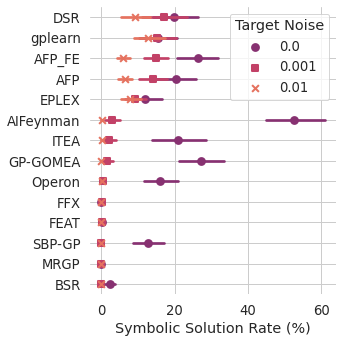

<Figure size 432x288 with 0 Axes>

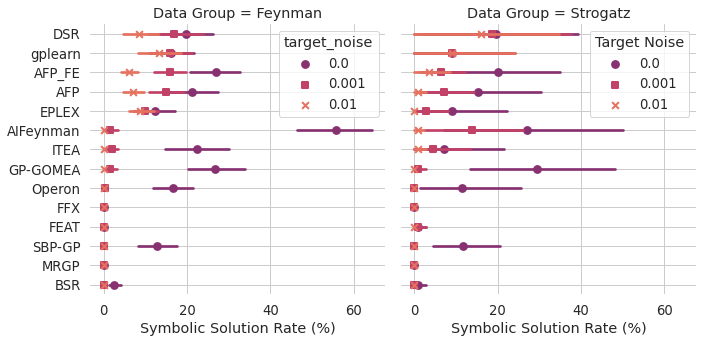

<Figure size 432x288 with 0 Axes>

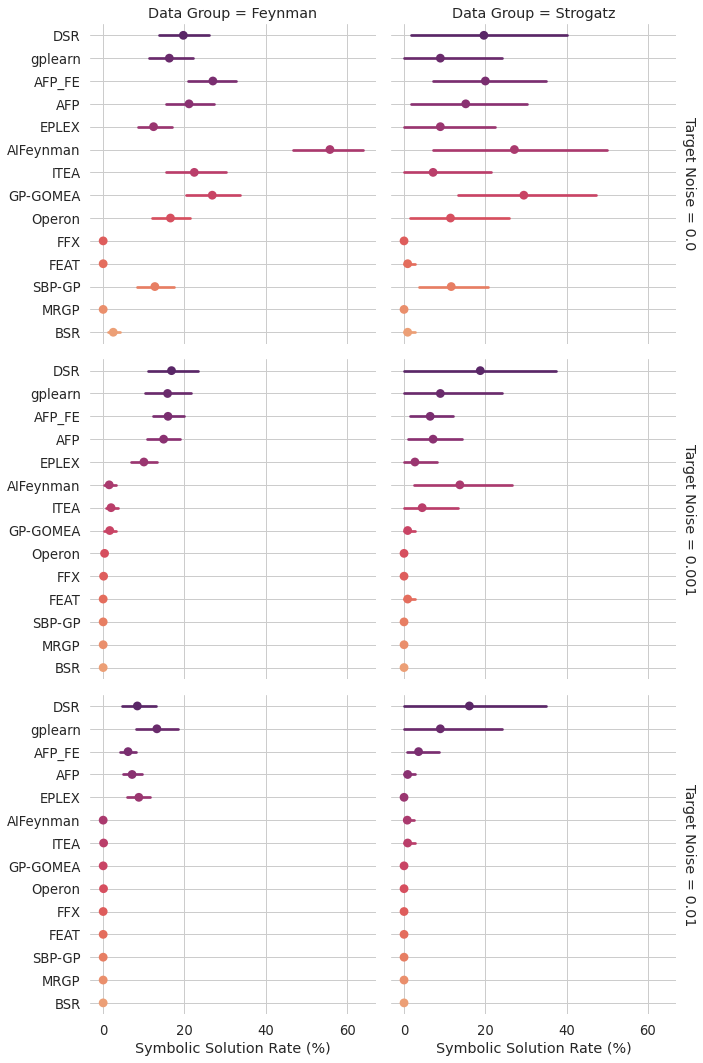

<Figure size 432x288 with 0 Axes>

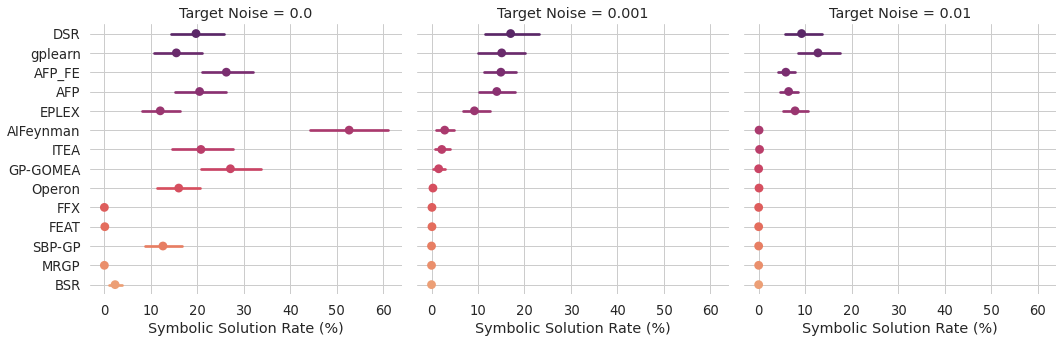

<Figure size 432x288 with 0 Axes>

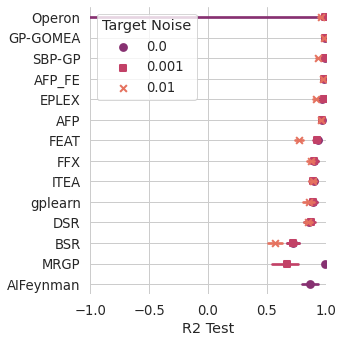

<Figure size 432x288 with 0 Axes>

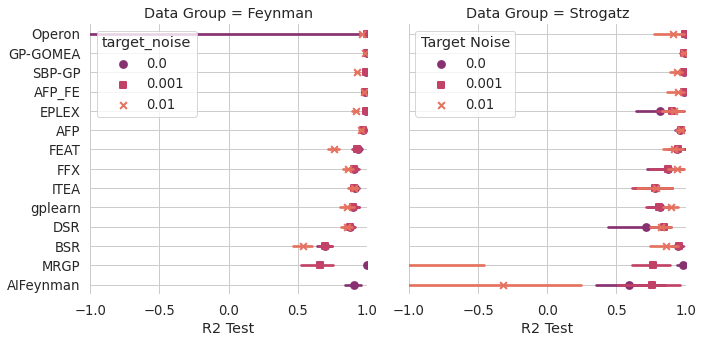

<Figure size 432x288 with 0 Axes>

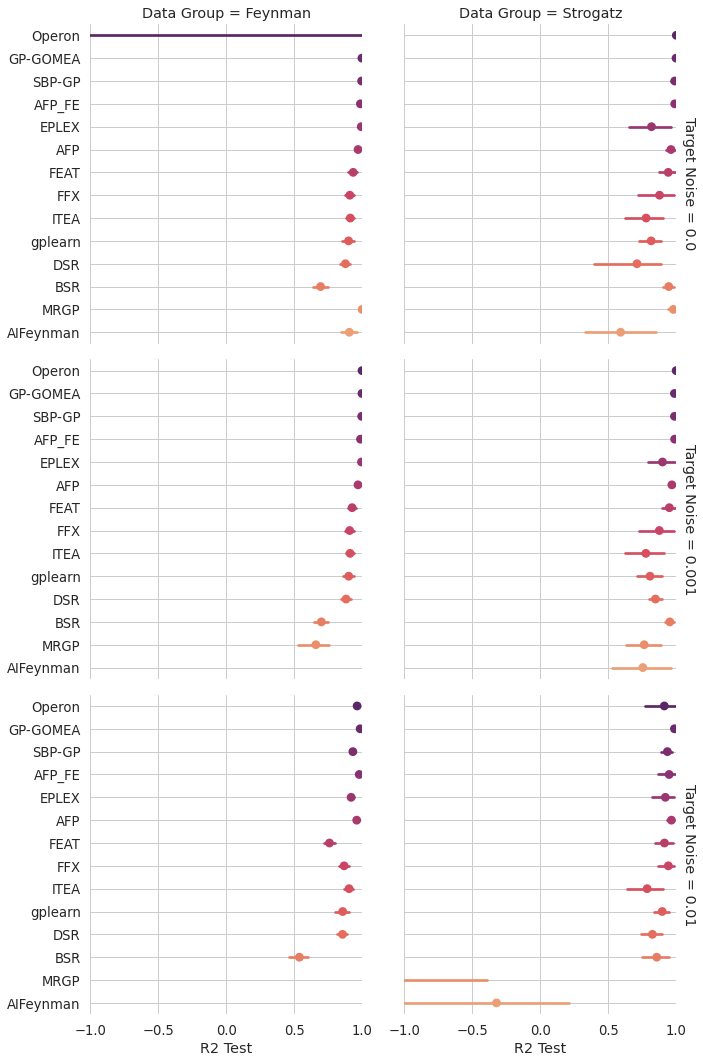

<Figure size 432x288 with 0 Axes>

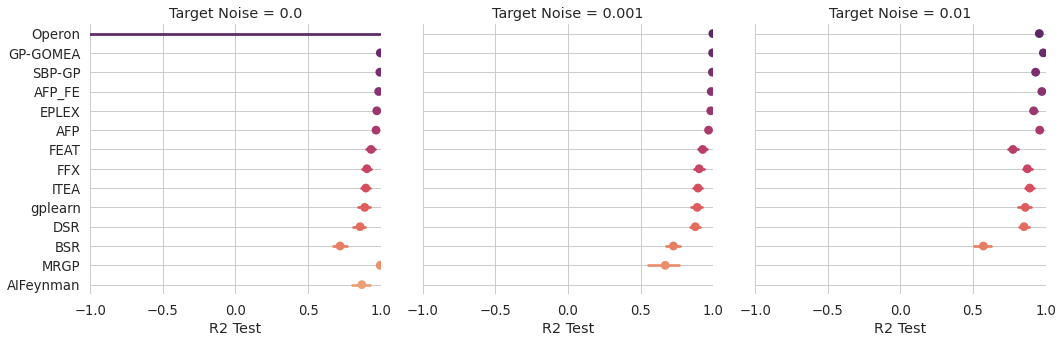

<Figure size 432x288 with 0 Axes>

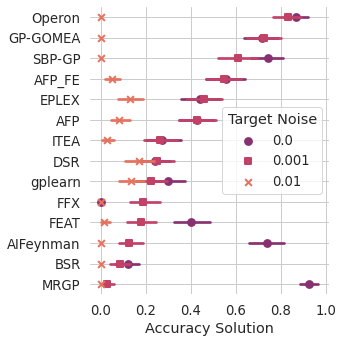

<Figure size 432x288 with 0 Axes>

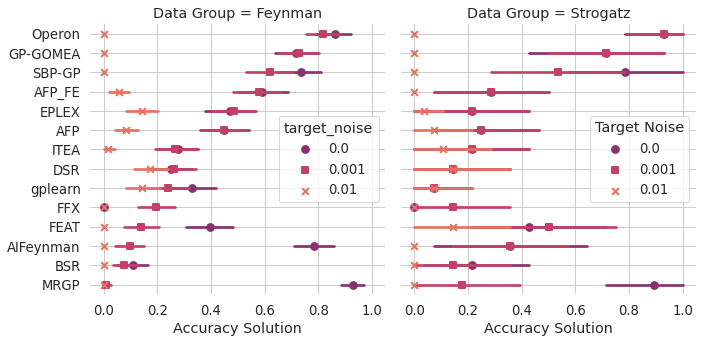

<Figure size 432x288 with 0 Axes>

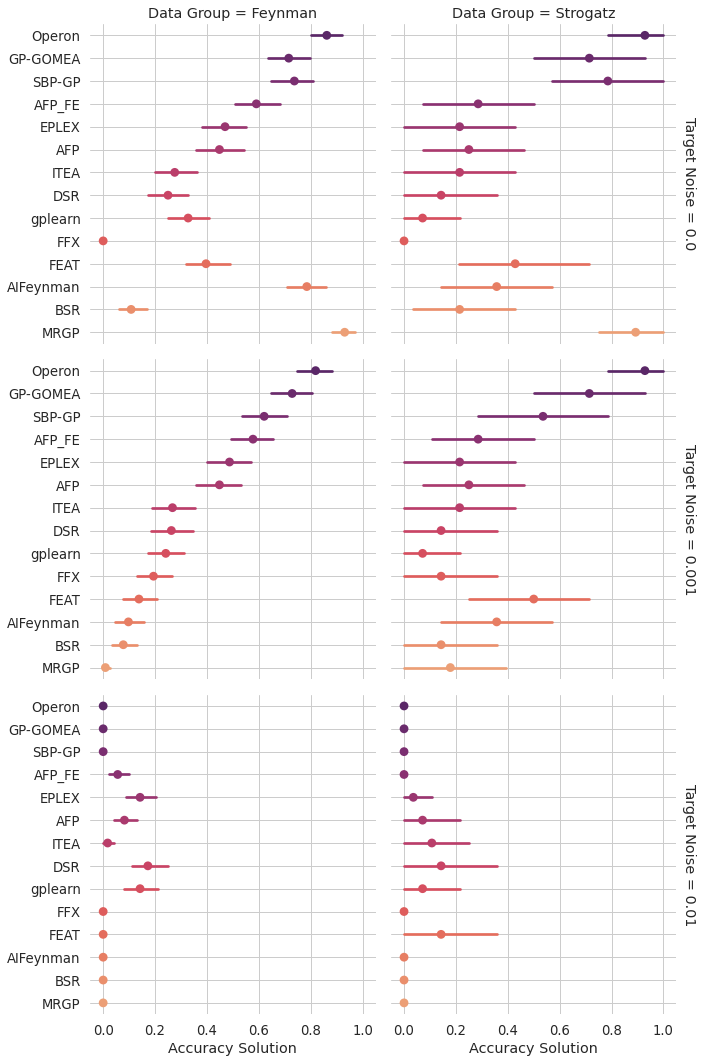

<Figure size 432x288 with 0 Axes>

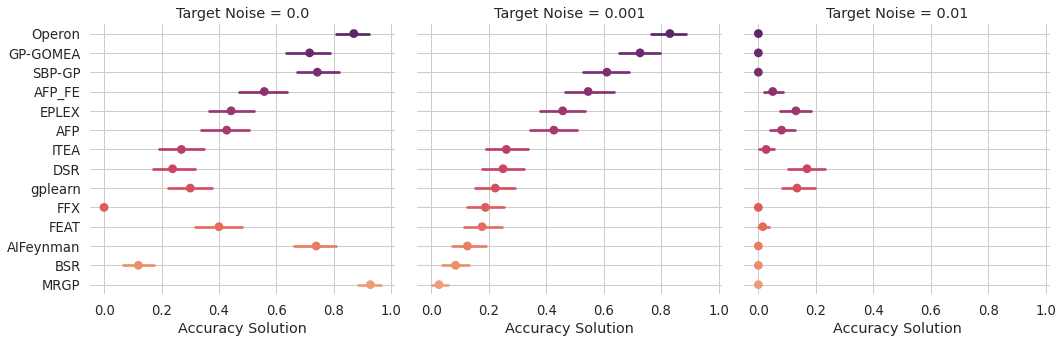

In [23]:
for metric in ['symbolic_solution_rate_(%)','r2_test','accuracy_solution']:
# for metric in ['r2_test']:
    for kind in ['point']: #,'strip']:
        args =dict(df_compare=df_sum, x=metric, est=np.mean, orient='h',
                   kind=kind) 
        if kind=='point': 
            args['join'] = False 
            args['markers']=['o','s','x']
        if metric == 'r2_test':
            args['xlim'] = [-1, 1]
        compare(**args,
                hue='target_noise', 
                col=None,
                ) 
        compare(**args, 
                hue='target_noise', 
                col='data_group',
                ) 
        compare(**args, 
                row='target_noise', 
                col='data_group',
                ) 
        compare(**args,
                col='target_noise', 
                ) 
# compare(df_sum, x='r2_test', hue='target_noise', est=np.mean, orient='h',kind=kind) #, scale='log') 
# for kind in ['point']:
#     compare(df_sum, x='r2_test', est=np.mean, orient='h',xlim=[0.0,1], kind=kind)
#     compare(df_sum, x='r2_test', row='target_noise', col='data_group',est=np.mean, orient='h',
#             xlim=[0.0,1], kind=kind)  
#     compare(df_sum, x='r2_test_rank', row='target_noise', col='data_group',est=np.mean, orient='h',
#             kind=kind) 
# compare(df_sum, x='mse_test', col='target_noise', xlim=[0,10]) #, scale='log') 
# compare(df_sum, x='r2_test', col='target_noise', xlim=[0,1])
# compare(df_sum, x='training time (s)', scale='log', col='target_noise')
# compare(df_sum, x='model_size', scale='log', col='target_noise')
# compare(df_sum, x='mse_test_rank', col='target_noise') 
# compare(df_sum, x='r2_test_rank', col='target_noise')

# scores on symbolic datasets

In [24]:

df_plot = df_sum.copy()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().median()
# tmp.median()
display(tmp)
order = tmp.sort_values(ascending=False).index
order

algorithm
AFP          0.140385
AFP_FE       0.149231
AIFeynman    0.028368
BSR          0.000000
DSR          0.170192
EPLEX        0.092308
FEAT         0.000962
FFX          0.000000
GP-GOMEA     0.015385
ITEA         0.022115
MRGP         0.000000
Operon       0.003077
SBP-GP       0.000000
gplearn      0.150962
dtype: float64

Index(['DSR', 'gplearn', 'AFP_FE', 'AFP', 'EPLEX', 'AIFeynman', 'ITEA',
       'GP-GOMEA', 'Operon', 'FEAT', 'SBP-GP', 'MRGP', 'FFX', 'BSR'],
      dtype='object', name='algorithm')

saving pairgrid_symbolic_solution_rate_(pct)_r2_test_simplified_complexity.pdf


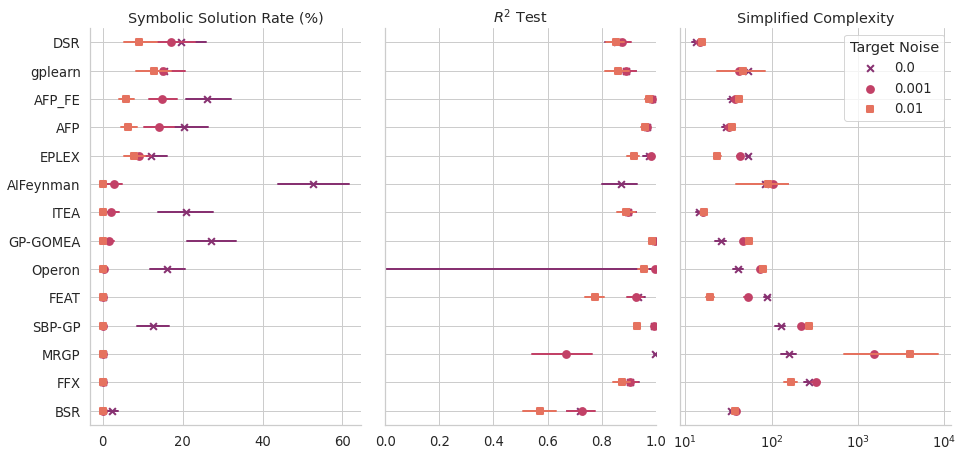

In [25]:
# Make the PairGrid
df_plot = df_sum.copy()
# df_plot['norm_r2_test'] = df_plot.groupby('dataset')['r2_test'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x+'*' if x in symbolic_algs else x)
# order = df_plot.groupby('algorithm')['symbolic_solution_rate'].mean().sort_values(ascending=False).index
# order = df_plot.loc[df_plot.target_noise==0.001].groupby('algorithm')['r2_test'].median().sort_values(ascending=False).index
# tmp = df_plot.groupby(['algorithm','target_noise'])['symbolic_solution_rate'].mean()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().median()
order = tmp.sort_values(ascending=False).index
# order = df_plot.groupby('algorithm')['symbolic_solution_rate'].mean().sort_values(ascending=False).index
# order = df_plot.loc[df_plot.target_noise==0.001].groupby('algorithm')['symbolic_solution_rate'].mean().sort_values(ascending=False).index
df_plot['size_diff'] = df_plot['model_size']-df_plot['simplified_complexity']+1
x_vars=[
#         'accuracy_solution_rate_(%)',
#         'mse_test',
#         'r2_test_rank',
#         'r2_test_norm',
        'symbolic_solution_rate_(%)',
        'r2_test',
        'simplified_complexity',
#         'size_diff',
#         'model_size',
#         'training time (s)',
#         'solution'
]
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5, 
                 aspect=0.7,
                 hue='target_noise',
#                  hue_order=[0.01,0.001,0]
#                  hue='dataset'
                )
g.map(sns.pointplot, 
#       size=10,
      orient="h",
      jitter=False,
      order=order,
      palette="flare_r",
      errwidth=2,
      linewidth=0.01,
      markeredgecolor='w',
      join=False,
      estimator=np.mean,
      n_boot=1000,
      linestyles=[':','--','-'],
      markers=['x','o','s'],
      markeralpha=0.5
     )
plt.legend(title='Target Noise')
# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# # Use semantically meaningful titles for the columns
# titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
#           "Not distracted crashes", "No previous crashes"]
titles = [x.replace('_',' ').title().replace('(S)','(s)') for x in x_vars]

for ax, title in zip(g.axes.flat, titles):

    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set a different title for each axes
    ax.set(title=title)
    
#     if any([n in title.lower() for n in ['size','time']]):
    if any([n in title.lower() for n in ['size','complexity','time']]):
        ax.set_xscale('log')
    if 'R2' in title and 'Rank' not in title:
        ax.set(title=title.replace('R2','$R^2$'))
        ax.set_xlim([0,1])

    # Make the grid horizontal instead of vertical
#     ax.xaxis.grid(True)
    ax.yaxis.grid(True)
# g.tight_layout()
# sns.despine(left=True, bottom=True)
save(g, 'pairgrid_'+'_'.join(x_vars))

## Pareto plot

In [26]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

saving pareto_plot_r2_test_rank_model_size_rank.pdf


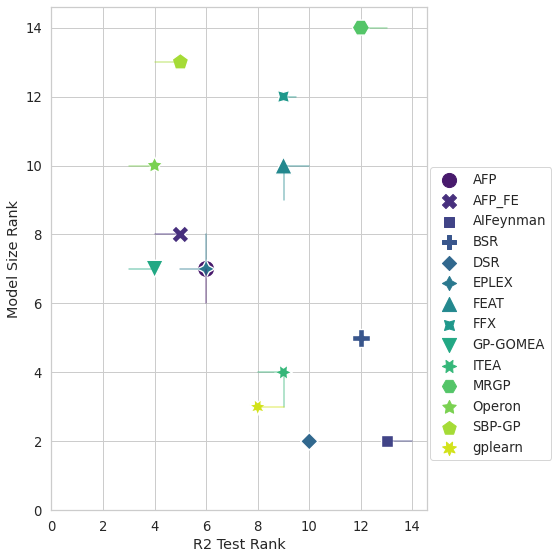

In [27]:
plt.figure(figsize=(8,8))
data = df_sum.copy()
xcol = 'r2_test_rank'
# xcol = 'symbolic_solution_rate_rank'
ycol = 'model_size_rank'
palette = 'viridis'
cmap = sns.color_palette(palette=palette, n_colors=data.algorithm.nunique(), desat=None, as_cmap=False)
Z = 1.96 # 95% confidence 
i = 0
for alg, dg in data.groupby('algorithm'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
#              [x-sdx,x+sdx],
             [cilx, ciux],
             [y, y],
             alpha=0.5,
             color=cmap[i]
            )
    plt.plot(
             [x, x],
#              [y-sdy,y+sdy],
             [cily, ciuy],
             alpha=0.5,
             color=cmap[i]
            )
    i += 1
ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
    data = data.groupby('algorithm').median(),
    x = xcol,
    y = ycol,
    style='algorithm',
    hue = 'algorithm',
    s=300,
    palette=palette,
    #     edgecolor='k'
)
handles = ax.get_legend_handles_labels()[0]
for lh in handles: 
    lh.set_alpha(1)
    lh._sizes = [200] 
ax.legend(handles=handles, loc=[1.01,0.1])
# ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.xlabel(xcol.replace('_',' ').title())
plt.ylabel(ycol.replace('_',' ').title())
save(plt.gcf(), name='pareto_plot_'+xcol+'_'+ycol)

saving cat-barplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Dataset.pdf


<Figure size 432x288 with 0 Axes>

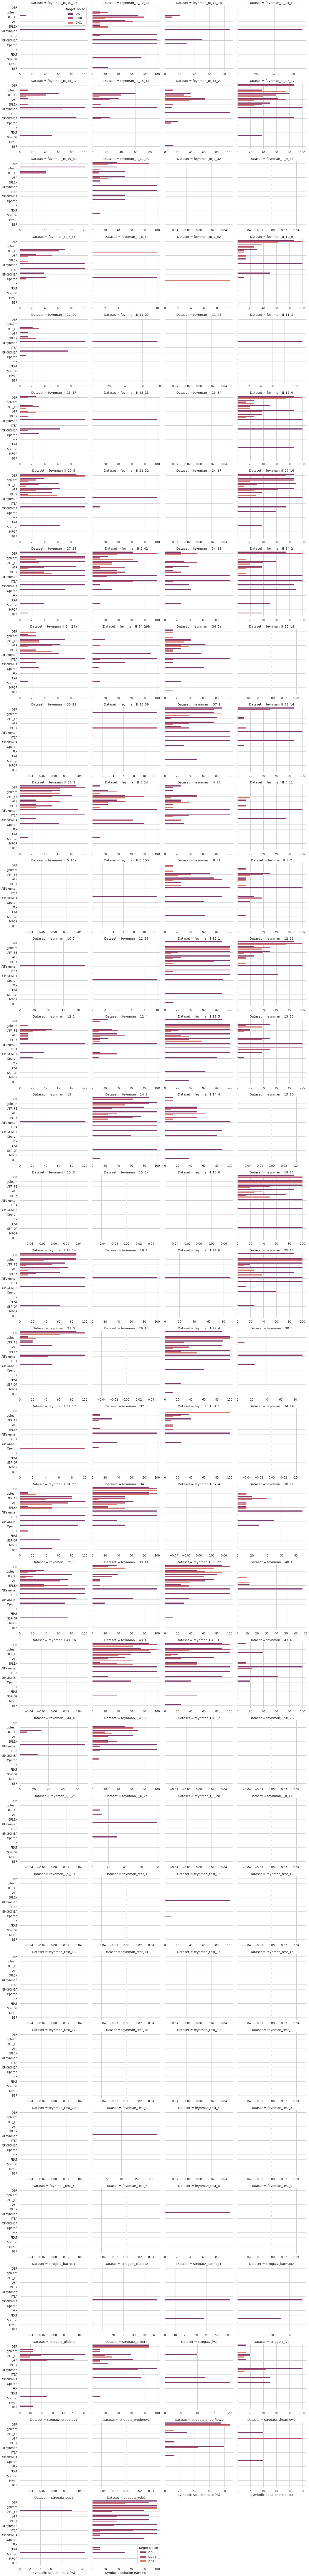

In [28]:
compare(df_sum, x='symbolic_solution_rate_(%)', hue='target_noise', col='dataset',est=np.mean, orient='h',
       sharex=False, kind='bar') #, scale='log') 